# Predict Bike Sharing Demand with AutoGluon Template

## Project: Predict Bike Sharing Demand with AutoGluon
This notebook is a template with each step that you need to complete for the project.

Please fill in your code where there are explicit `?` markers in the notebook. You are welcome to add more cells and code as you see fit.

Once you have completed all the code implementations, please export your notebook as a HTML file so the reviews can view your code. Make sure you have all outputs correctly outputted.

`File-> Export Notebook As... -> Export Notebook as HTML`

There is a writeup to complete as well after all code implememtation is done. Please answer all questions and attach the necessary tables and charts. You can complete the writeup in either markdown or PDF.

Completing the code template and writeup template will cover all of the rubric points for this project.

The rubric contains "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. The stand out suggestions are optional. If you decide to pursue the "stand out suggestions", you can include the code in this notebook and also discuss the results in the writeup file.

## Step 1: Create an account with Kaggle

### Create Kaggle Account and download API key
Below is example of steps to get the API username and key. Each student will have their own username and key.

1. Open account settings.
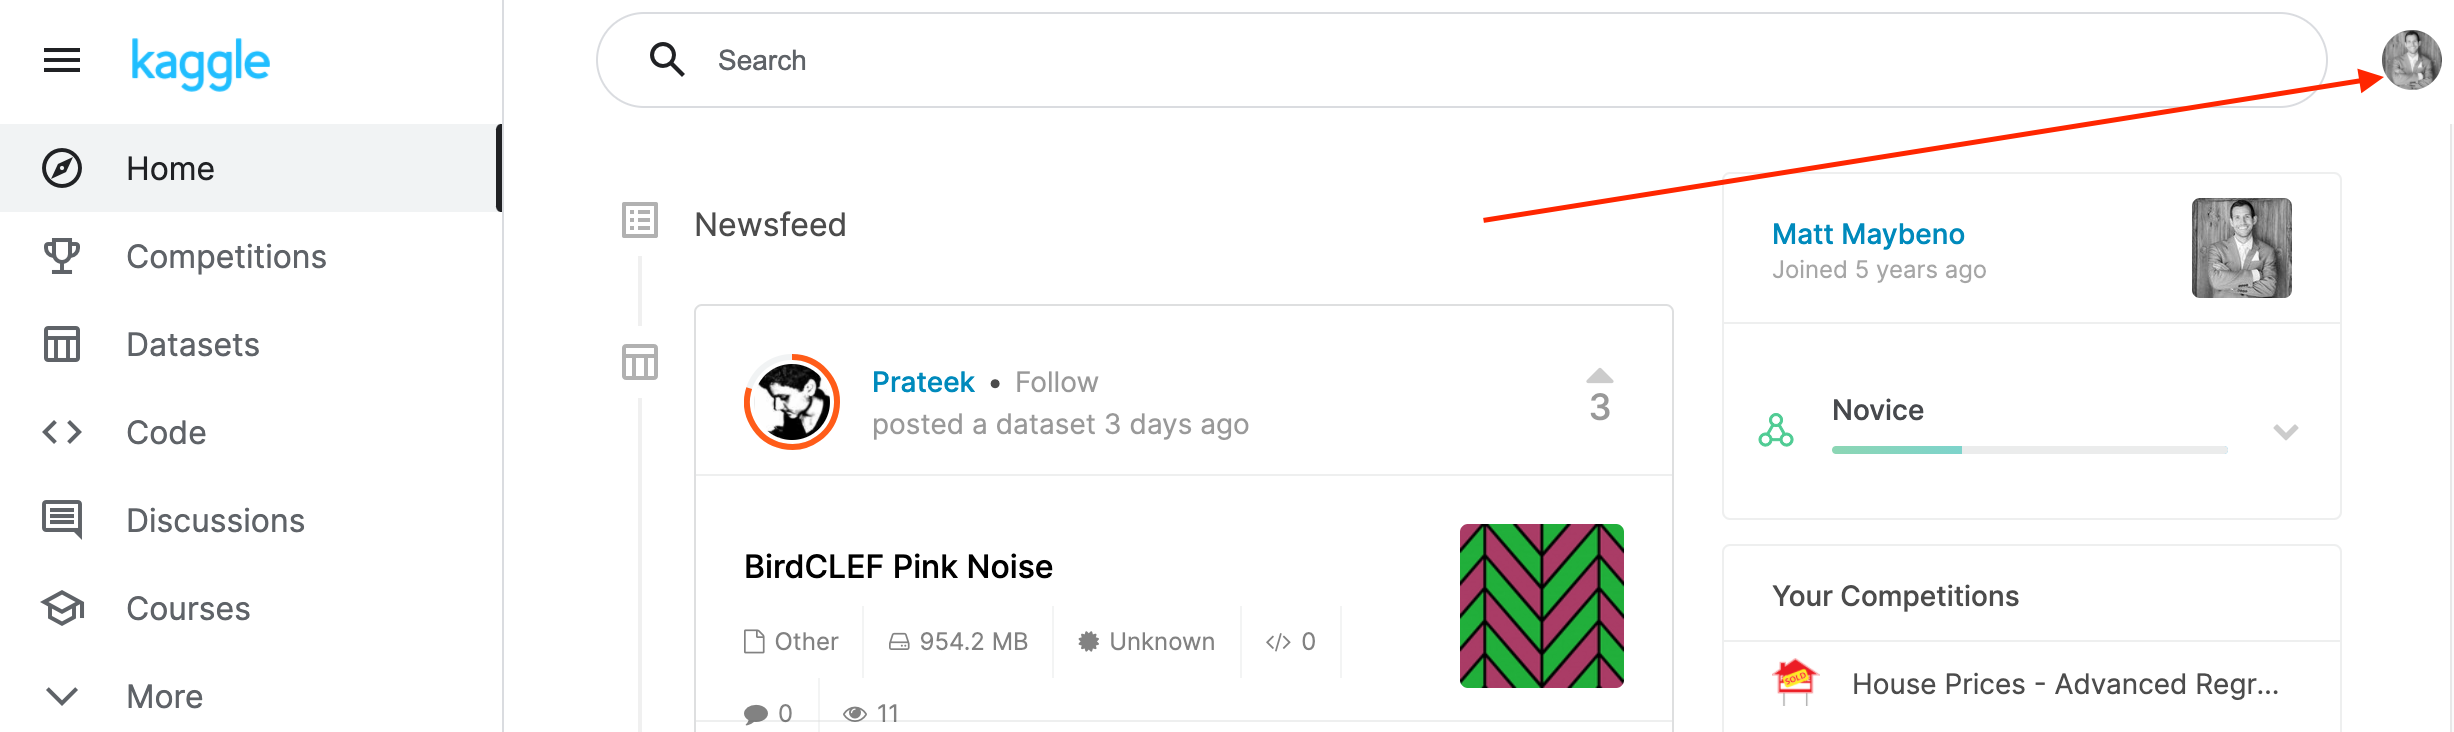
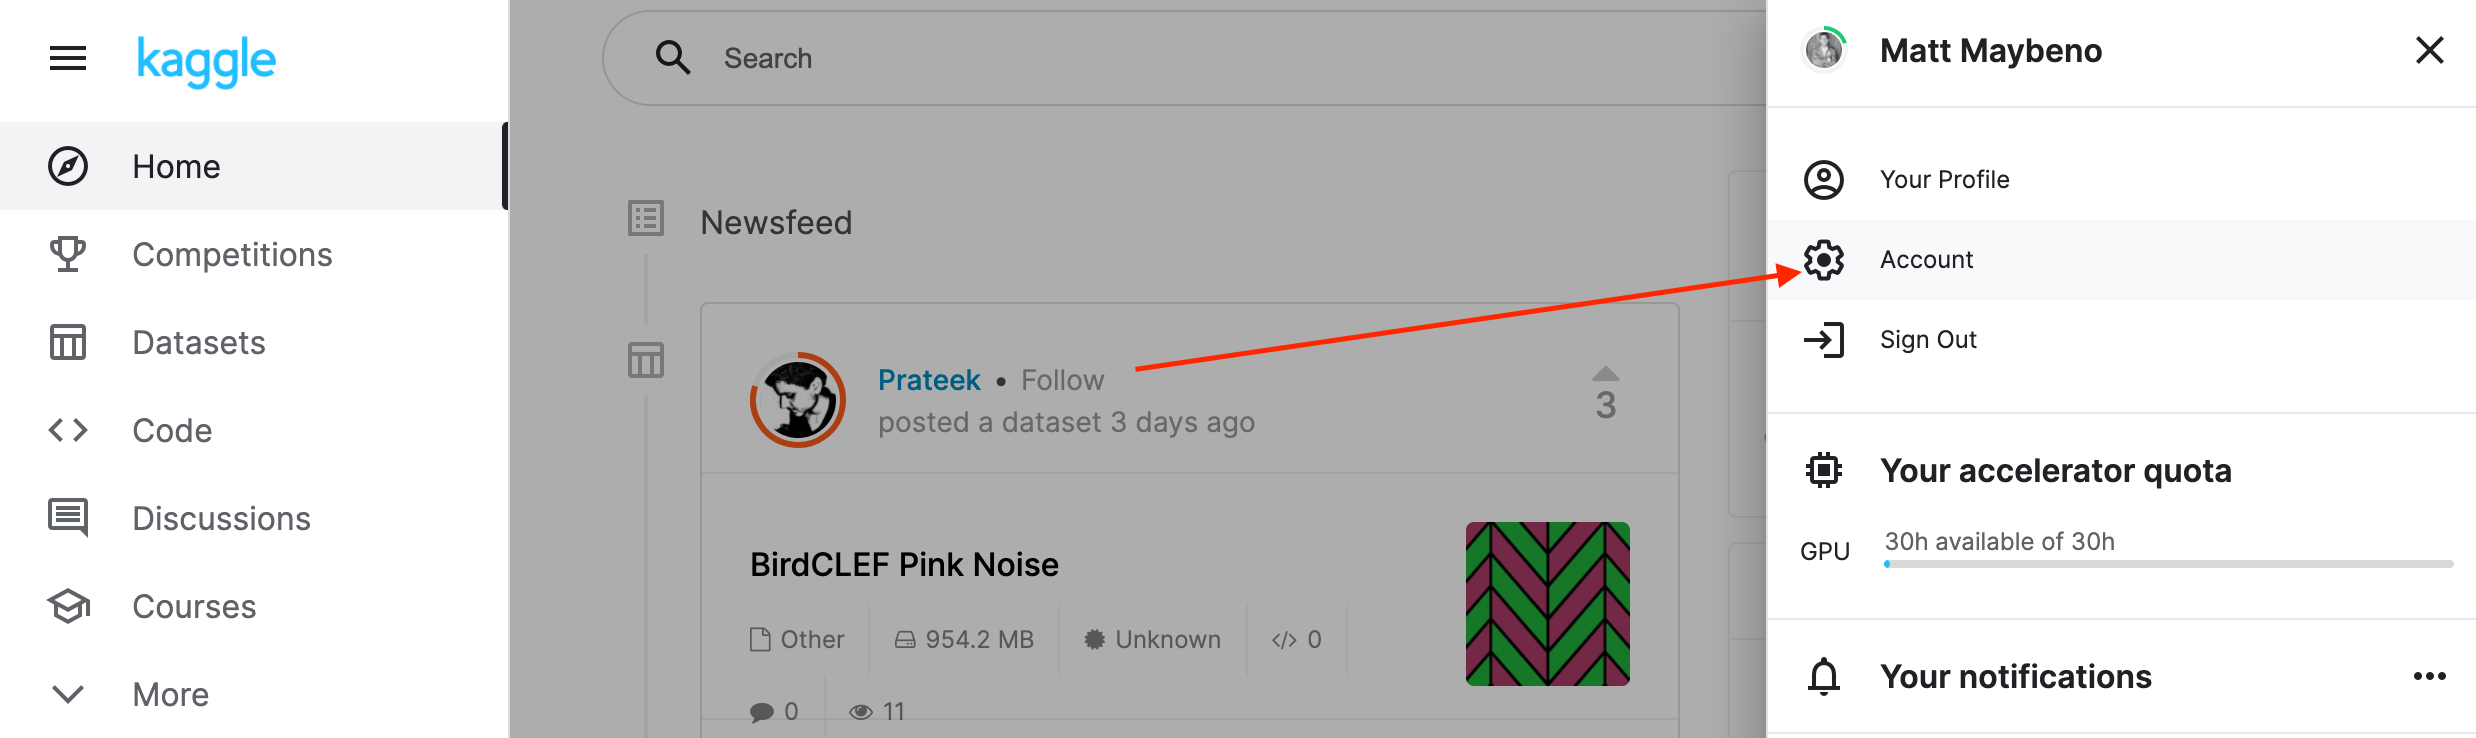
2. Scroll down to API and click Create New API Token.
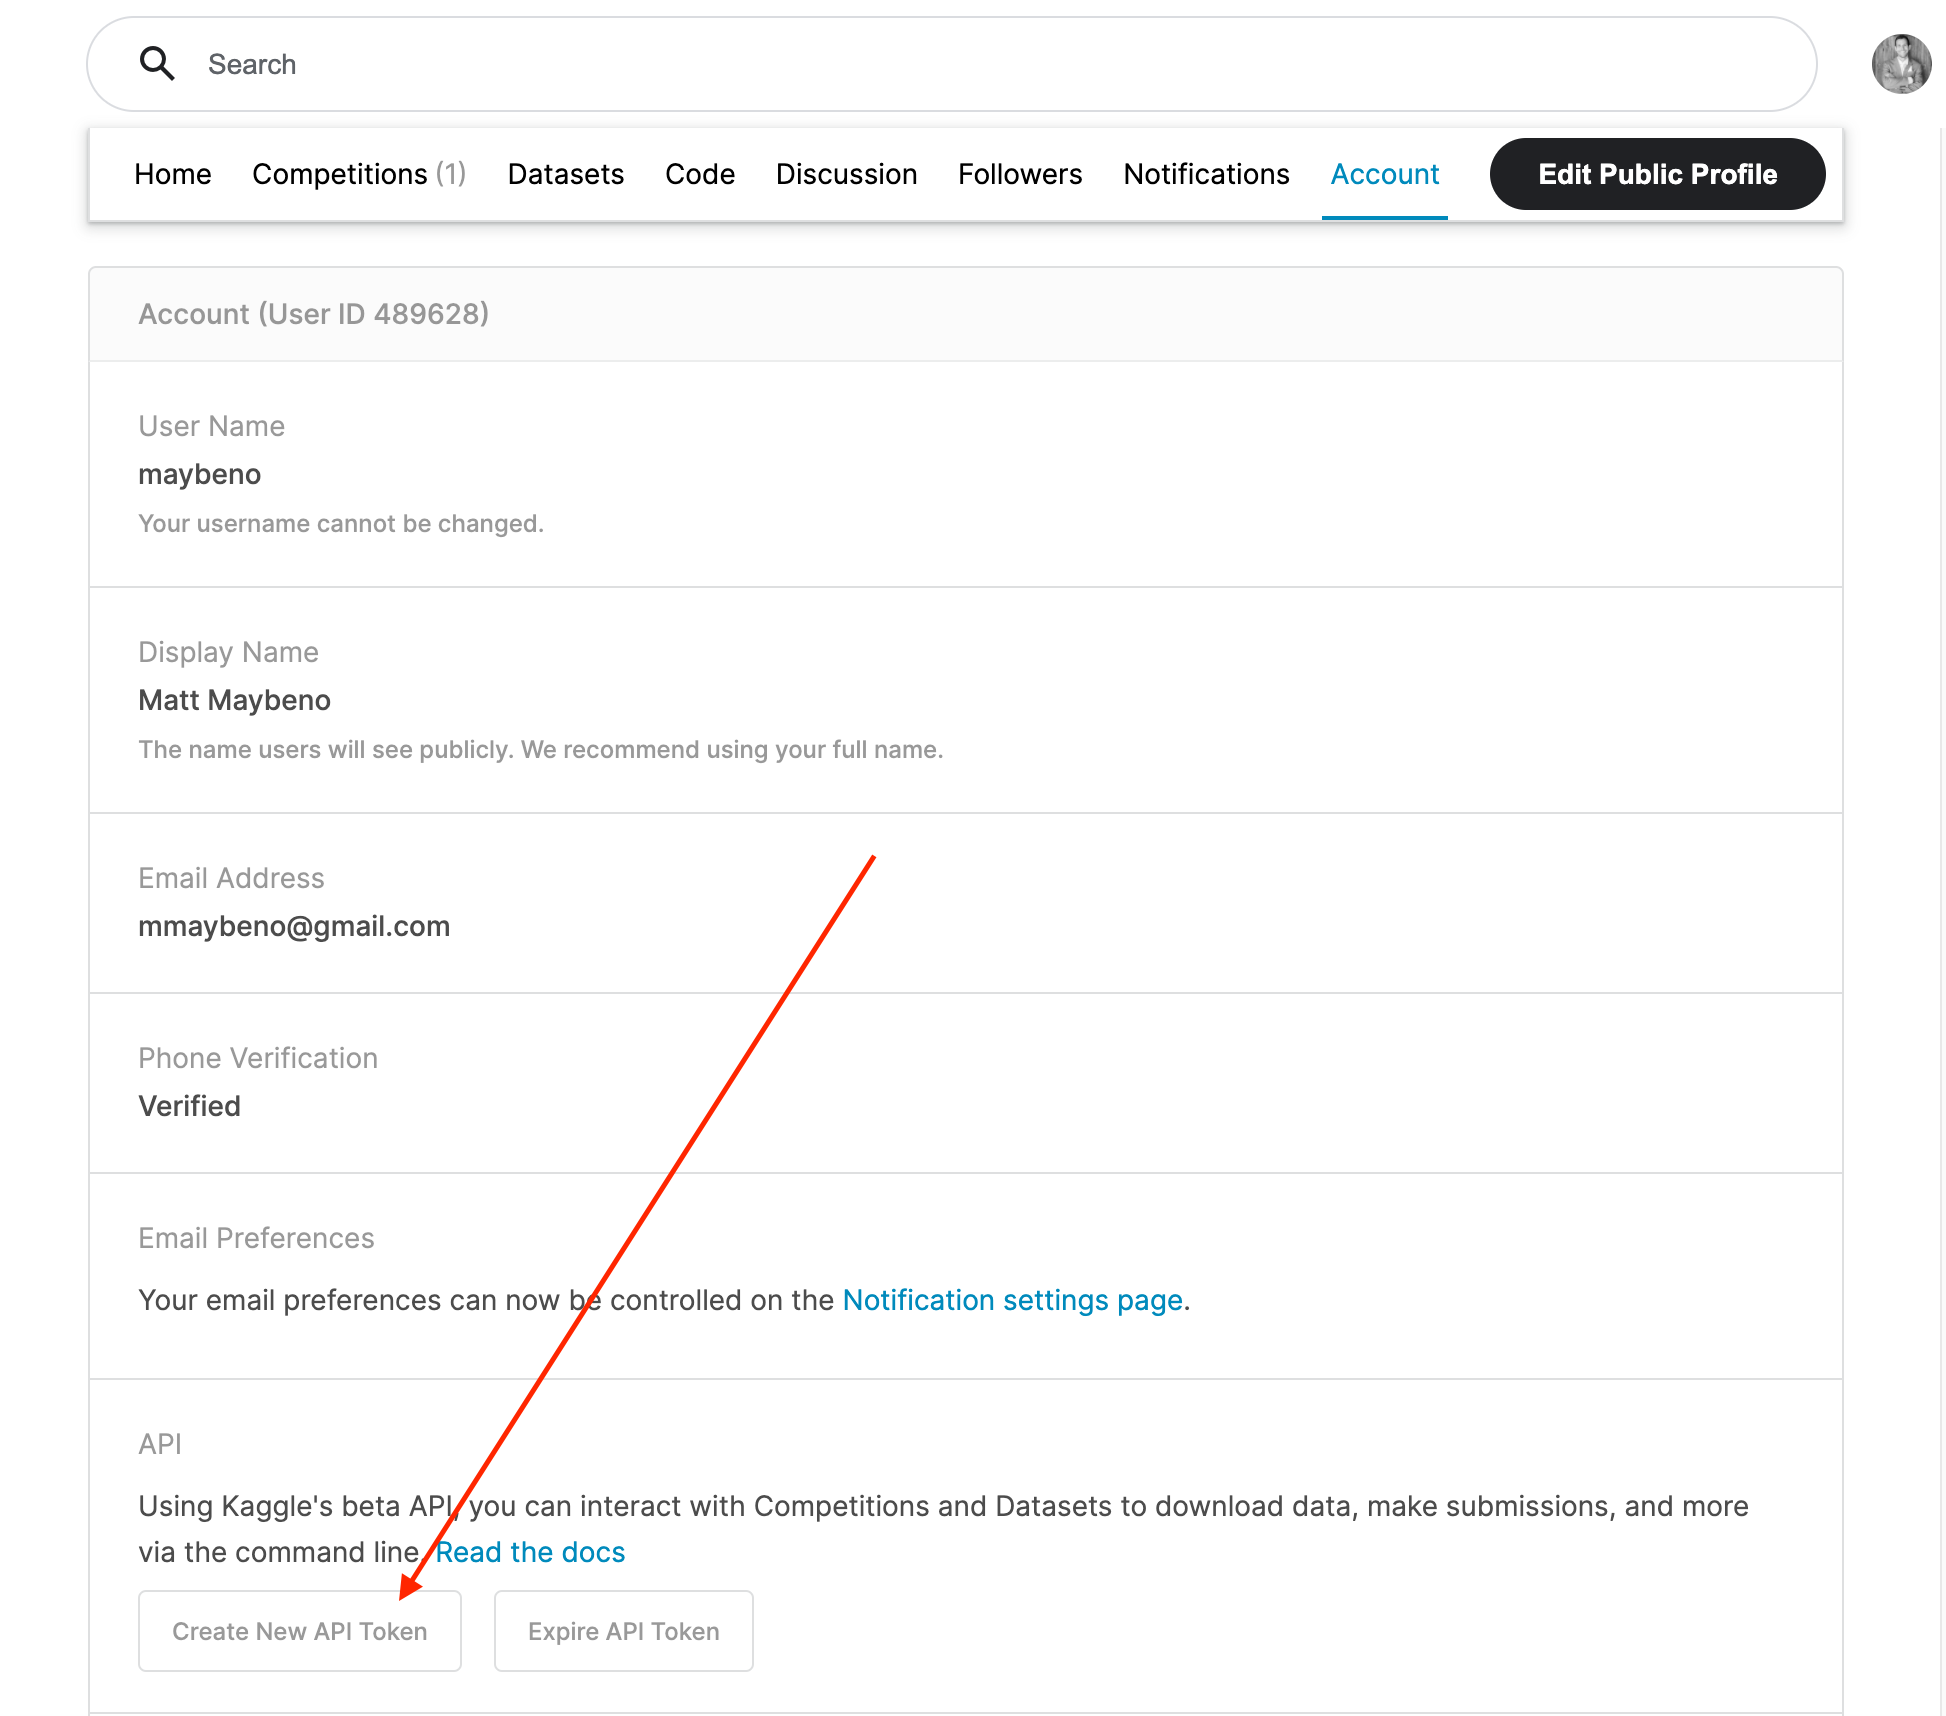
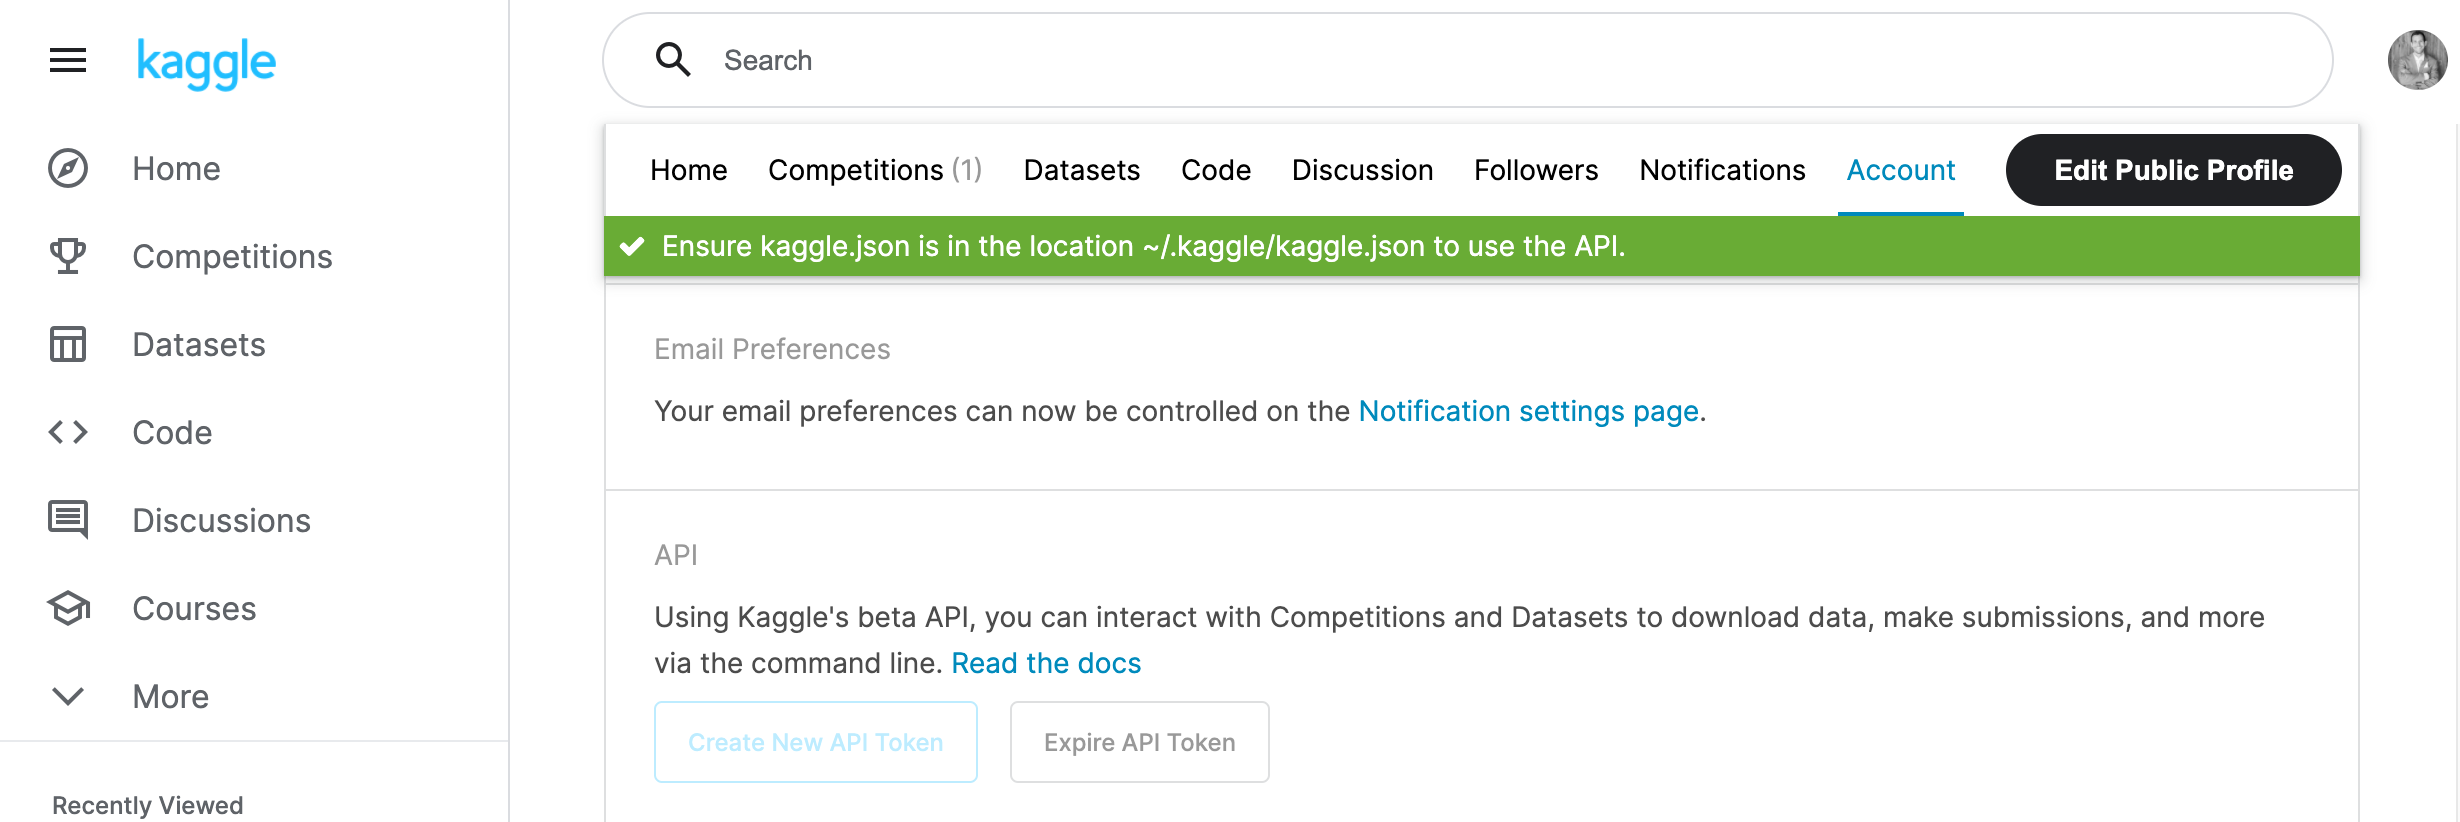
3. Open up `kaggle.json` and use the username and key.
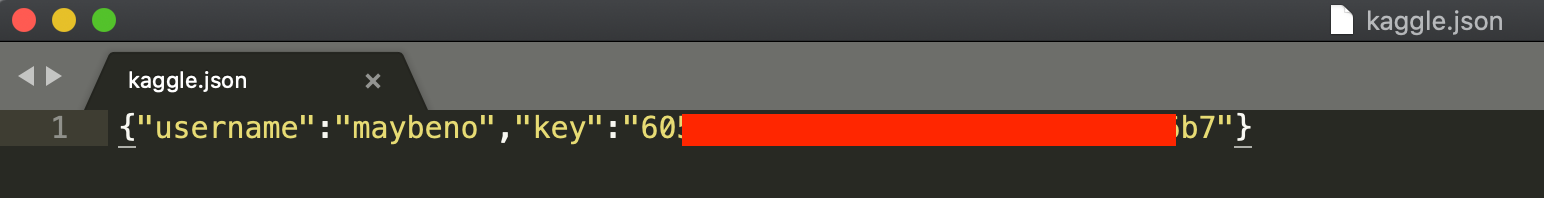

## Step 2: Download the Kaggle dataset using the kaggle python library

### Open up Sagemaker Studio and use starter template

1. Notebook should be using a `ml.t3.medium` instance (2 vCPU + 4 GiB)
2. Notebook should be using kernal: `Python 3 (MXNet 1.8 Python 3.7 CPU Optimized)`

### Install packages

In [ ]:
!pip install -U pip
!pip install -U setuptools wheel
!pip install -U "mxnet<2.0.0" bokeh==2.0.1
!pip install autogluon --no-cache-dir
# Without --no-cache-dir, smaller aws instances may have trouble installing

In [2]:
conda install -c conda-forge lightgbm

Channels:
 - conda-forge
 - defaults
 - pytorch-nightly
 - apple
Platform: osx-arm64
Solving environment: done

## Package Plan ##

  environment location: /Users/kalai/miniforge3/envs/env_tf

  added / updated specs:
    - lightgbm


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    lightgbm-4.0.0             |  py310h980d568_0         1.1 MB  conda-forge
    llvm-openmp-15.0.7         |       h7cfbb63_0         257 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         1.3 MB

The following NEW packages will be INSTALLED:

  lightgbm           conda-forge/osx-arm64::lightgbm-4.0.0-py310h980d568_0 

The following packages will be UPDATED:

  llvm-openmp                             15.0.6-h7cfbb63_0 --> 15.0.7-h7cfbb63_0 



lightgbm-4.0.0       | 1.1 MB    |                                       |   0% 
ll

### Setup Kaggle API Key

In [8]:
# create the .kaggle directory and an empty kaggle.json file
!mkdir -p /Users/kalai/.kaggle
!touch /Users/kalai/.kaggle/kaggle.json
!chmod 600 /Users/kalai/.kaggle/kaggle.json

In [11]:
# Fill in your user name and key from creating the kaggle account and API token file
import json
kaggle_username = "jyothikc"
kaggle_key = "f1ede1363ead537b9d8cfc9ffd099611"

# Save API token the kaggle.json file
with open("/Users/kalai/.kaggle/kaggle.json", "w") as f:
    f.write(json.dumps({"username": kaggle_username, "key": kaggle_key}))

### Download and explore dataset

### Go to the [bike sharing demand competition](https://www.kaggle.com/c/bike-sharing-demand) and agree to the terms
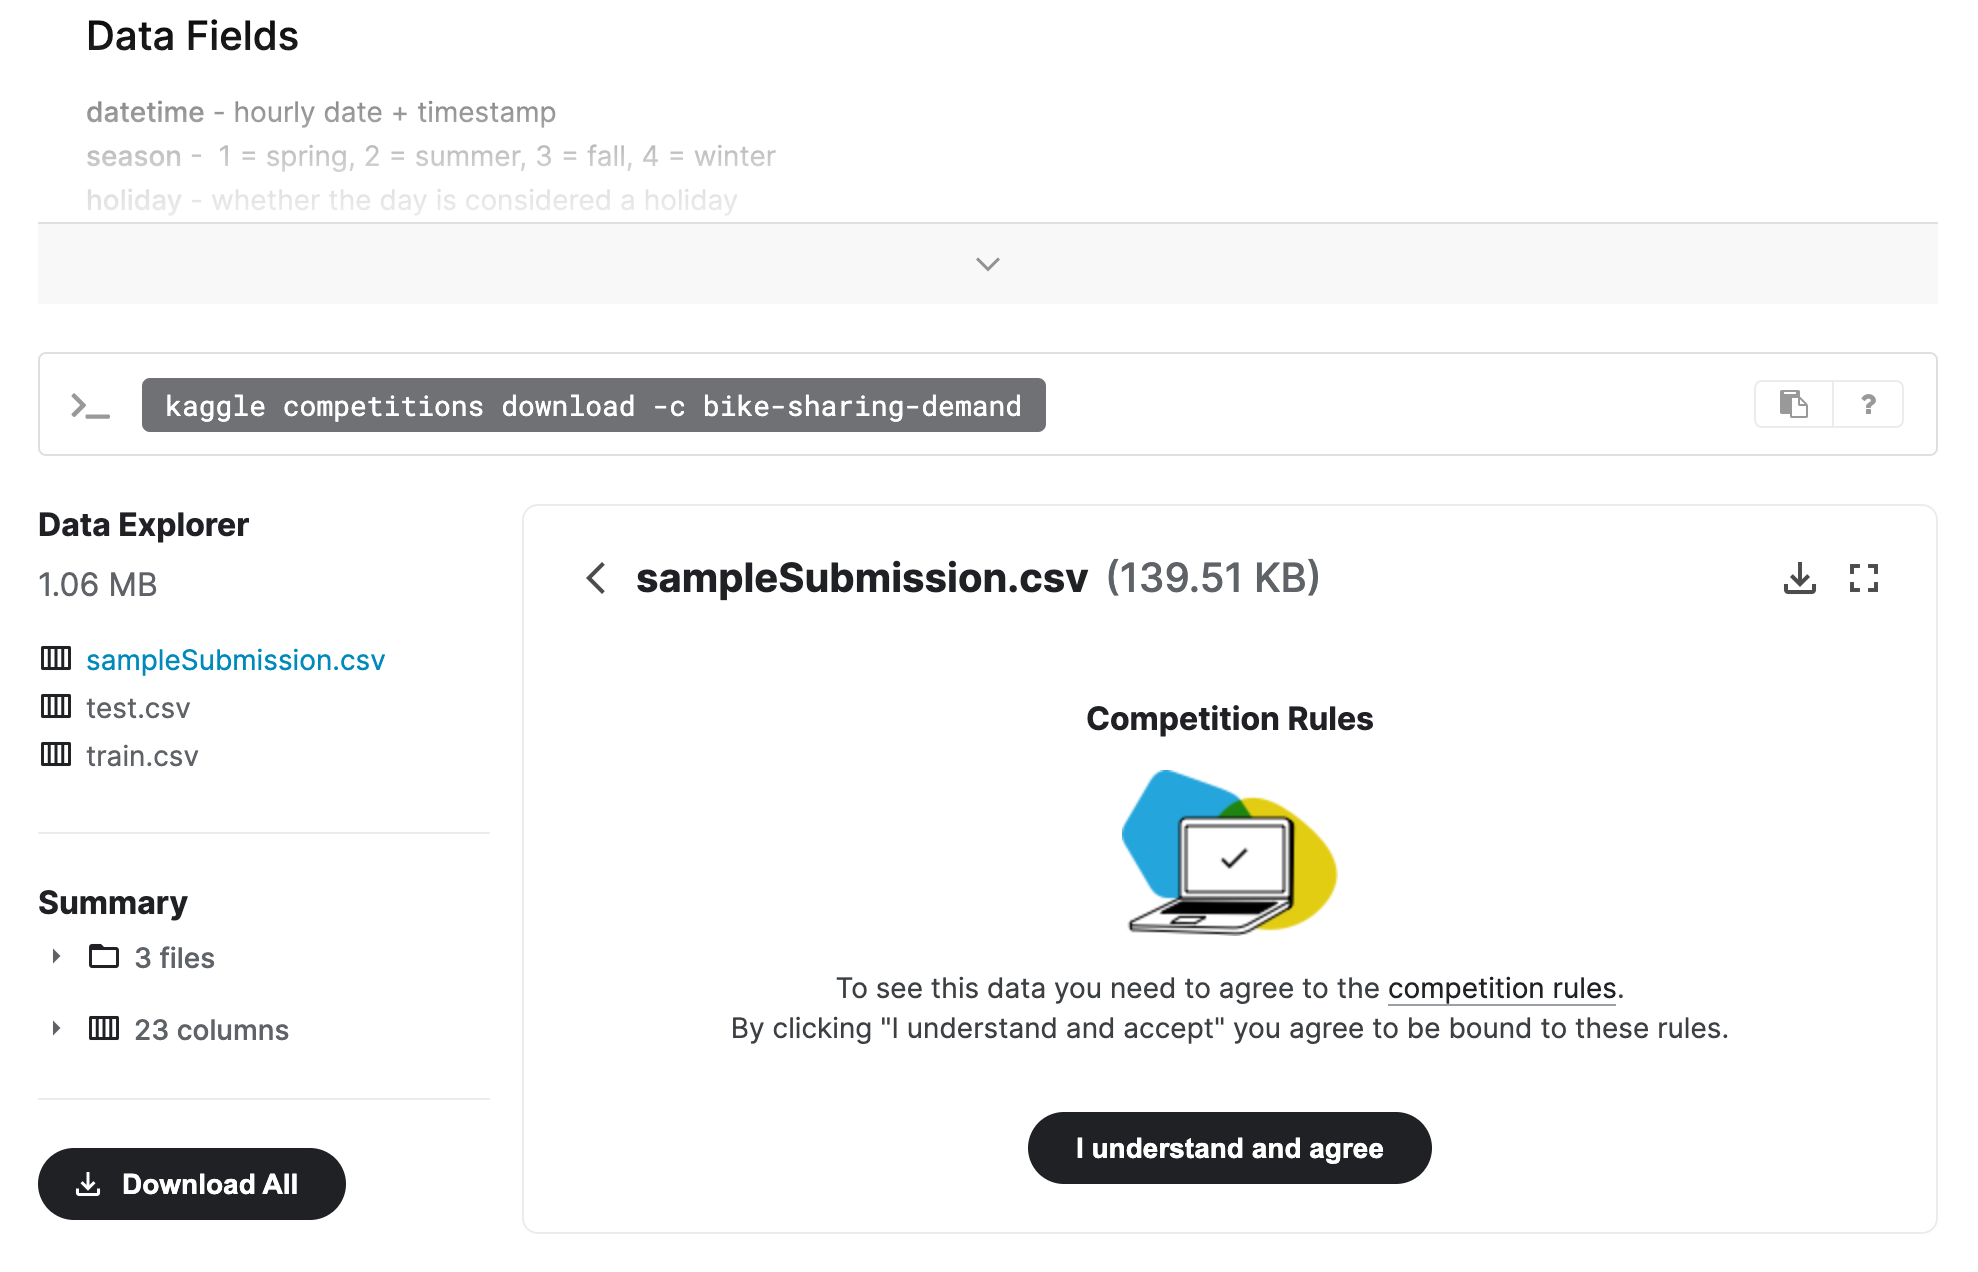

In [12]:
# Download the dataset, it will be in a .zip file so you'll need to unzip it as well.
!kaggle competitions download -c bike-sharing-demand
# If you already downloaded it you can use the -o command to overwrite the file
!unzip -o bike-sharing-demand.zip

100%|█████████████████████████████████████████| 189k/189k [00:00<00:00, 286kB/s]
100%|█████████████████████████████████████████| 189k/189k [00:00<00:00, 286kB/s]
Archive:  bike-sharing-demand.zip
  inflating: sampleSubmission.csv    
  inflating: test.csv                
  inflating: train.csv               


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from autogluon.tabular import TabularPredictor
import warnings
warnings.filterwarnings('ignore')
import autogluon.common as ag

In [2]:
# Create the train dataset in pandas by reading the csv
# Set the parsing of the datetime column so you can use some of the `dt` features in pandas later
train = pd.read_csv("train.csv",parse_dates=['datetime'])
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [3]:
# Simple output of the train dataset to view some of the min/max/varition of the dataset features.
train.describe()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2011-12-27 05:56:22.399411968,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
min,2011-01-01 00:00:00,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2011-07-02 07:15:00,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,2012-01-01 20:30:00,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,2012-07-01 12:45:00,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,2012-12-19 23:00:00,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000
std,NaN,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454


In [4]:
# Create the test pandas dataframe in pandas by reading the csv, remember to parse the datetime!
test = pd.read_csv("test.csv",parse_dates=['datetime'])
test.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


In [5]:
# Same thing as train and test dataset
submission = pd.read_csv("sampleSubmission.csv",parse_dates=['datetime'])
submission.head()

,datetime,count
0,2011-01-20 00:00:00,0
1,2011-01-20 01:00:00,0
2,2011-01-20 02:00:00,0
3,2011-01-20 03:00:00,0
4,2011-01-20 04:00:00,0


## Step 3: Train a model using AutoGluon’s Tabular Prediction

Requirements:
* We are predicting `count`, so it is the label we are setting.
* Ignore `casual` and `registered` columns as they are also not present in the test dataset. 
* Use the `root_mean_squared_error` as the metric to use for evaluation.
* Set a time limit of 10 minutes (600 seconds).
* Use the preset `best_quality` to focus on creating the best model.

In [6]:
#Requirements
label = 'count'
ignore_columns =['casual','registered']
time_limit= 600
eval_metric ='root_mean_squared_error'
presets = 'best_quality'

In [27]:
predictor= TabularPredictor(eval_metric=eval_metric,label=label,
                            learner_kwargs= {'ignored_columns':ignore_columns}).fit(train_data=train,
                                                                                    presets= presets,
                                                                                    time_limit=time_limit)

No path specified. Models will be saved in: "AutogluonModels/ag-20240426_101347"
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
Dynamic stacking is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
Detecting stacked overfitting by sub-fitting AutoGluon on the input data. That is, copies of AutoGluon will be sub-fit on subset(s) of the data. Then, the holdout validation data is used to detect stacked overfitting.
Sub-fit(s) time limit is: 600 seconds.
Starting holdout-based sub-fit for dynamic stacking. Context path is: AutogluonModels/ag-20240426_101347/ds_sub_fit/sub_fit_ho.
Running the sub-fit in a ray process to avoid memory leakage.
Spend 154 seconds

In [7]:
#Loading the initial model
predictor= TabularPredictor.load("AutogluonModels/ag-20240426_101347")

### Review AutoGluon's training run with ranking of models that did the best.

In [8]:
predictor.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                          model   score_val              eval_metric  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0           WeightedEnsemble_L3  -49.791866  root_mean_squared_error      33.317392  280.953644                0.000365           0.062635            3       True         35
1   NeuralNetFastAI_r191_BAG_L2  -50.554324  root_mean_squared_error      32.946804  271.149802                0.121413          19.960949            2       True         34
2        NeuralNetFastAI_BAG_L2  -51.938924  root_mean_squared_error      32.914245  259.303005                0.088854           8.114151            2       True         29
3        RandomForestMSE_BAG_L2  -53.328397  root_mean_squared_error      33.195614  260.930060                0.370223           9.741206            2       True         26
4               LightGBM_BAG_L2  -55.050846  root_mean_squared_error

{'model_types': {'KNeighborsUnif_BAG_L1': 'StackerEnsembleModel_KNN',
  'KNeighborsDist_BAG_L1': 'StackerEnsembleModel_KNN',
  'LightGBMXT_BAG_L1': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L1': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L1': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L1': 'StackerEnsembleModel_XT',
  'NeuralNetFastAI_BAG_L1': 'StackerEnsembleModel_NNFastAiTabular',
  'XGBoost_BAG_L1': 'StackerEnsembleModel_XGBoost',
  'LightGBMLarge_BAG_L1': 'StackerEnsembleModel_LGB',
  'CatBoost_r177_BAG_L1': 'StackerEnsembleModel_CatBoost',
  'LightGBM_r131_BAG_L1': 'StackerEnsembleModel_LGB',
  'NeuralNetFastAI_r191_BAG_L1': 'StackerEnsembleModel_NNFastAiTabular',
  'CatBoost_r9_BAG_L1': 'StackerEnsembleModel_CatBoost',
  'LightGBM_r96_BAG_L1': 'StackerEnsembleModel_LGB',
  'XGBoost_r33_BAG_L1': 'StackerEnsembleModel_XGBoost',
  'ExtraTrees_r42_BAG_L1': 'StackerEnsembleModel_XT',
  'CatBoost_r137_BAG_L1': 'Stacke

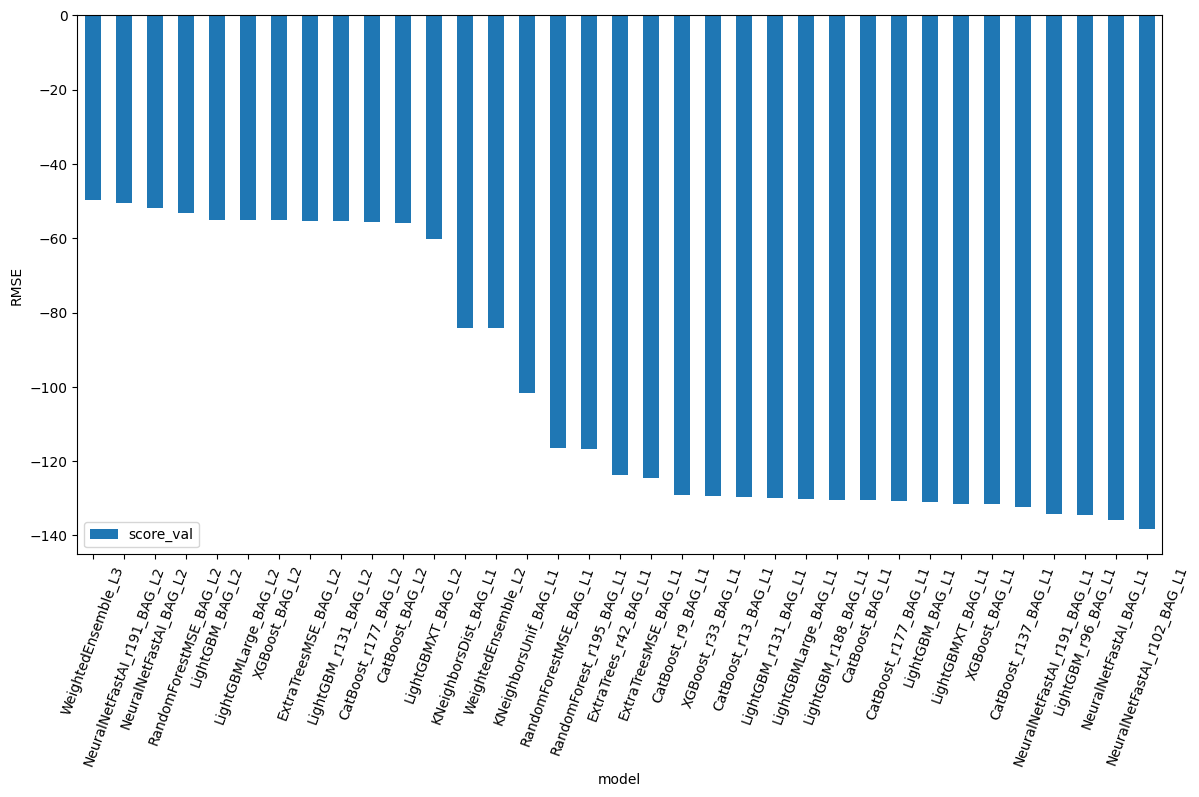

In [9]:
# for clarity, plot the comparison of models' initial performances
# leaderboard_df = pd.DataFrame(predictor.leaderboard())
# leaderboard_df
predictor.leaderboard(silent=True).plot(kind='bar',x='model',y='score_val',figsize=(14,7))
plt.ylabel('RMSE')
plt.xticks(rotation=70);

### Create predictions from test dataset

In [11]:
predictions = predictor.predict(test)
predictions.head()

0    22.419798
1    37.470169
2    43.017784
3    46.308617
4    49.156181
Name: count, dtype: float32

In [ ]:
#### NOTE: Kaggle will reject the submission if we don't set everything to be > 0.

In [12]:
# Describe the `predictions` series to see if there are any negative values
predictions.describe()

count    6493.000000
mean       98.830780
std        88.648994
min         0.856103
25%        19.849667
50%        66.913864
75%       168.974640
max       351.787659
Name: count, dtype: float64

In [13]:
# How many negative values do we have?
neg_prediction_count= predictions[predictions<0].sum()
print(neg_prediction_count)

0.0


Since all predictions are positive we can proceed.

### Set predictions to submission dataframe, save, and submit

In [14]:
submission["count"] = predictions
submission.to_csv("submission.csv", index=False)

In [49]:
!kaggle competitions submit -c bike-sharing-demand -f submission.csv -m "first raw submission"

100%|█████████████████████████████████████████| 188k/188k [00:01<00:00, 110kB/s]
Successfully submitted to Bike Sharing Demand

#### View submission via the command line or in the web browser under the competition's page - `My Submissions`

In [50]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

fileName                     date                 description                        status    publicScore  privateScore  
---------------------------  -------------------  ---------------------------------  --------  -----------  ------------  
submission.csv               2024-04-26 11:49:50  first raw submission               complete  1.8704       1.8704        
submission_new_hpo.csv       2022-02-17 21:13:01  new features with hyperparameters  complete  0.51462      0.51462       
submission_new_features.csv  2022-02-17 20:33:43  new features                       complete  1.38602      1.38602       


#### Initial score of `1.8704`

## Step 4: Exploratory Data Analysis and Creating an additional feature
* Any additional feature will do, but a great suggestion would be to separate out the datetime into hour, day, or month parts.

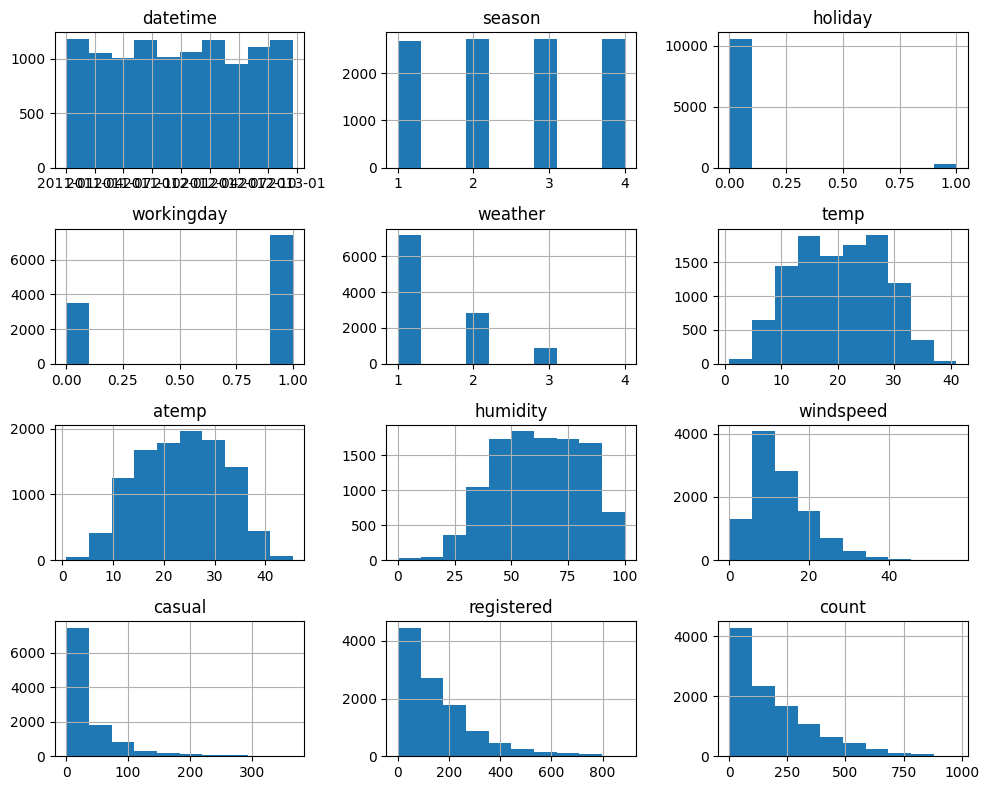

In [7]:
# Create a histogram of all features to show the distribution of each one relative to the data. This is part of the exploritory data analysis
train.hist(figsize=(10,8))
plt.tight_layout()
plt.show();

#### Observations - Histogram

Description of the `weather` labels on the Kaggle page-

1: Clear, Few clouds, Partly cloudy, Partly cloudy.

2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist.

3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds.

4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog.

- The `season` seems to have a uniform distribution , with all four seasons being equally likely.
- `season` and `weather` are categorical variables.
- We can observe higher bike rental demands in good weather(1 and 2).
- `Casual` and `registered` are ignored as they are absent in the dataset.
- `Windspeed` is slightly left-skewed.
- `Temp` and `atemp` are normally distributed approximately.
- `Working` and `holiday` are categorical variable with values as yes(1) and no(0).
- People mainly rent bikes only for work, as seen from the `Working` and `holiday` histograms.

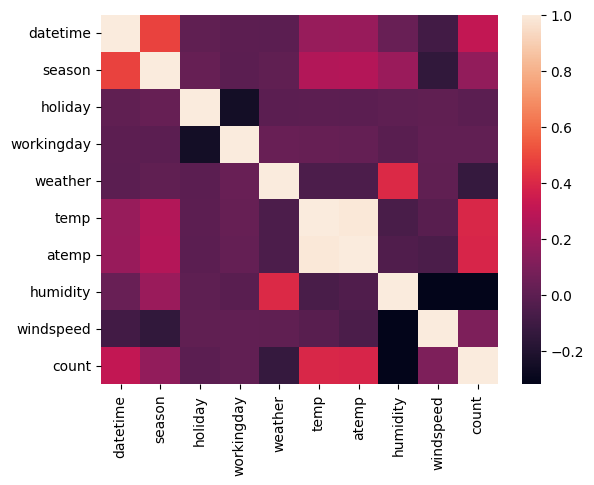

In [7]:
sns.heatmap(train.drop(columns=['casual','registered'],axis=1).corr());

#### Observations - Heatmap
- `temp` and `atemp` show a correlation ~ 1, which makes sense since atemp is the feels-like temperature.
- Target `count` decreases with increase in humidity, negative correlation ~ <-0.2
- `holiday` and `workingday` have negative correlation < ~ -0.2
- `windspeed` decreases with increase in `humidity` and has no correlation to `season`, `weather` and `temp`.
- `count` has no correlation with `workingday` , `humidity` and positive correlation with `temp`,`atemp` and`datetime`.

In [8]:
#Number of unique values
print(f"Year values:{train.datetime.dt.year.nunique()}\nMonth values: {train.datetime.dt.month.nunique()} \nDay values: {train.datetime.dt.day.nunique()}") 

Year values:2
Month values: 12 
Day values: 19


We can infer from above that,
- `year` is a discrete variable, as the bike rental records are provided for only 2011 and 2012.
- The number of bike rentals remains almost the same except around the beginning and end of the year.
- The bike rentals drop significantly near days 7-8,according to days, which might indicate a holiday.


In [7]:
#Since all three sub-variables have values where a pattern might be detected, we transform them into seperate features
train['year'] = train.datetime.dt.year
train['month']= train.datetime.dt.month
train['day']=train.datetime.dt.day
train["hour"] = train["datetime"].dt.hour
test['year'] = test.datetime.dt.year
test['month']=test.datetime.dt.month
test['day']= test.datetime.dt.day
test['hour'] = test.datetime.dt.hour

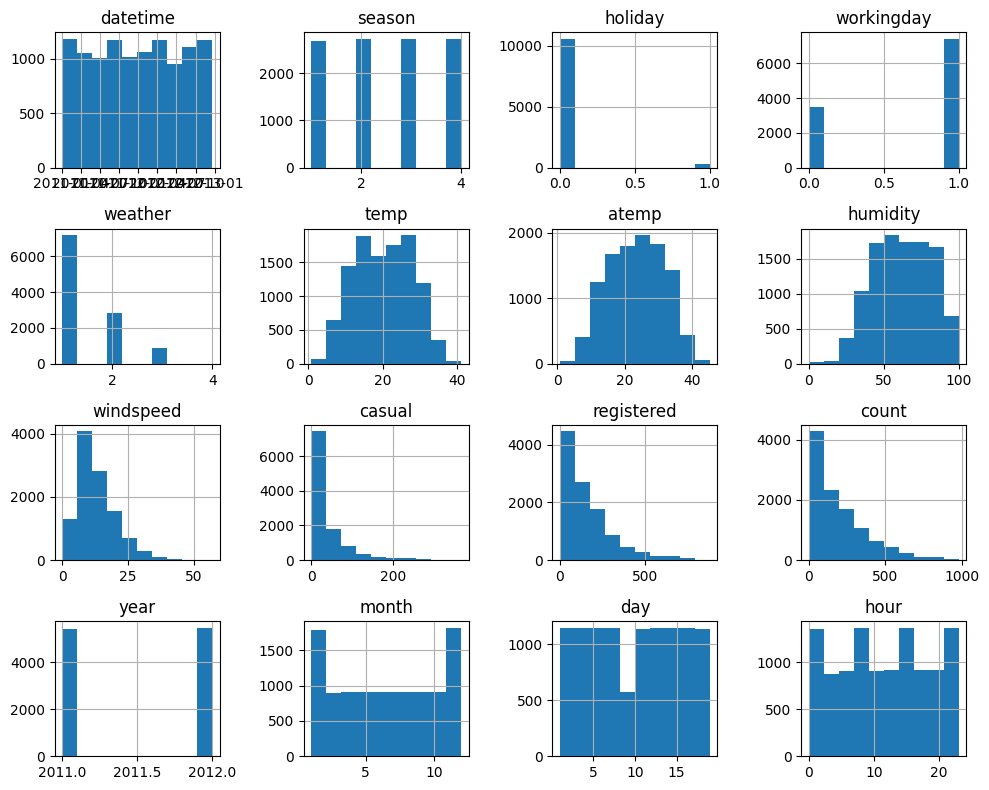

In [8]:
#plot histogram for comparison again
train.hist(figsize=(10,8))
plt.tight_layout()
plt.show()

#### Observations-  Histogram with new features
- `year` ,`holiday`,`workingday` , `season` and `weather` are discrete distributions, hence plotting bar charts of these features against the total rentals(target) , `count` , might give insights into the trends.
- `casual` and `registered` are excluded , since they are not available in the test column.
- The remaining continuous variables will be depicted with line plots to observe their changes w.r.t `count`.

In [9]:
line_cols=pd.Series(data= ['windspeed','humidity','temp','atemp','hour','day'])
bar_cols=pd.Series(data=['holiday','month','weather','workingday','season'])
sns.set_theme(style="darkgrid")

In [13]:
def plot_line():
    """
    Plots line plot for the select features against number of bikes rented and w.r.t year.
    """
    fig,axes= plt.subplots(6,1,figsize=(10,15));
    fig.subplots_adjust(hspace=0.5, wspace=0.2)
    for i,j in enumerate(line_cols):
        line= sns.lineplot(data=train,x=j,y='count',hue='year',ax=axes[i])
        line.set(xlabel=j,ylabel='Number of bikes rented' )

In [14]:
def plot_bar():
    """ 
    Plots bar charts for the remaining features(except casual and registered) against number of bikes rented and w.r.t year.
    """
    fig, axes= plt.subplots(5,1,figsize=(10,15));
    fig.subplots_adjust(hspace=0.5, wspace=0.2)
    for i,j in enumerate(bar_cols):
        line= sns.barplot(data=train,x=j,y='count',hue='year',ax=axes[i])
        line.set(xlabel=j,ylabel='Number of bikes rented' )

None


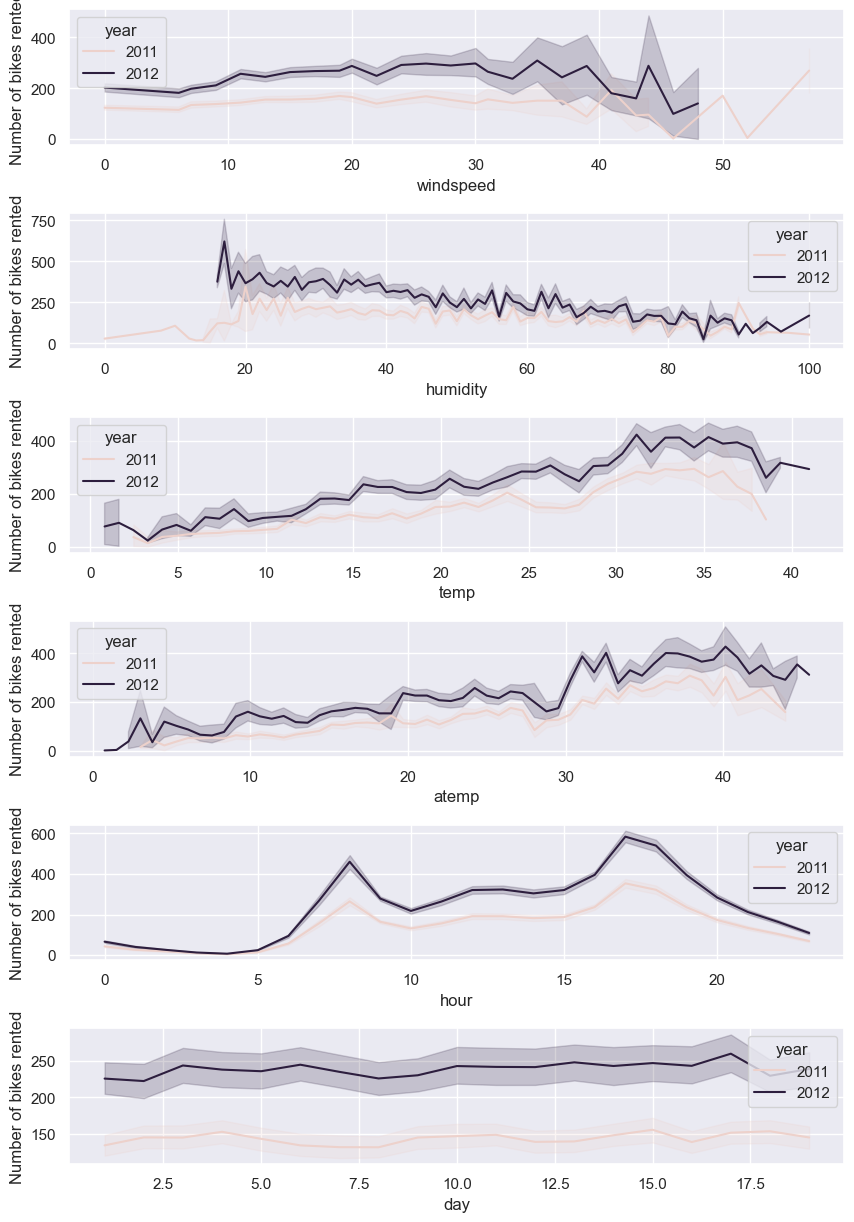

In [15]:
print(plot_line());

None


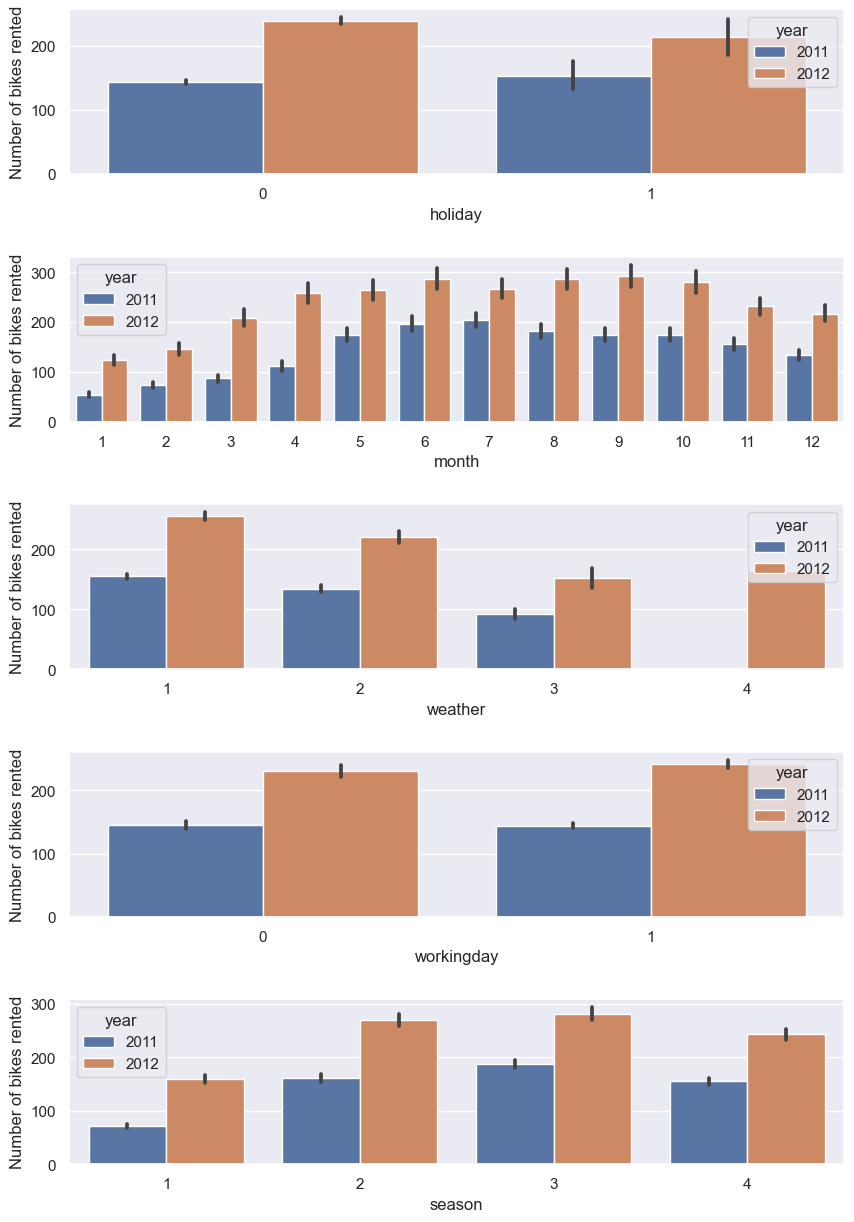

In [16]:
print(plot_bar());

#### Observations- Trend Analysis
- Overall, 2012 has higher rental demand, irrespective of other features.
- The `count` increases with increase in `temp`.
- The highest bike rental demand is, 250 approx. for 2012 and 150 approx. in 2011, when the sky is clear and also partly cloudy (1 in `weather`).
- `count` is the highest in fall (3) followed by summer (2), from the `season` plot. This aligns with the `weather` observation; The highest demands are observed by (1) and (2), which have characteristics pertaining to summer and fall.
- Bike rentals decrease with increase in `windspeed`.
- Although in 2011, demand for bikes remained the same for both working days and non-working days, in 2012, slight increase was observed in working days.
- There is a lesser demand for bikes on holidays, which possibly indicates there is more demand on working days or weekends.
- There is a possibility of creating a new feature `weekend` based on the values of `holiday` and `workingday`, when both are 0, `weekend` could be 1 and 0 vice-versa.
- The bike rentals increase with increase in `atemp`, feels -like temperature upto 40 degree, after which it drops, implying that people do not bike when it is too hot. This aligns with `temp` which also observes that the rentals drop from 35 degree.
- There is not much insight into the variation of rentals w.r.t `day` in dates.
- Bikes are rented the least from night to early hours ; Around 8am there is a spike in rentals(450 in 2012) - possible cause might be people commuting to work or school ; The rentals drop in morning to mid-day hours and shoot up again around 4:30- 5 pm,commuting hours again. 

### New Feature: `day_type`
- We will combine weekend , workingday and holiday into one feature `day_type`.


In [10]:
train['day_type']= ""
train.loc[(train.holiday == 0 & (train.workingday == 0)),"day_type"] = 'weekend'
train.loc[(train.holiday == 1),"day_type"] ='holiday'
train.loc[(train.workingday == 1,"day_type")]  ='workingday'

In [11]:
#Checking the values of day_type
print(train.day_type.unique())

['weekend' 'workingday' 'holiday']


In [12]:
#Doing the same for the test dataset
test['day_type']= ""
test.loc[(test.holiday == 0 & (test.workingday == 0)),"day_type"] = 'weekend'
test.loc[(test.holiday == 1),"day_type"] ='holiday'
test.loc[(test.workingday == 1,"day_type")]  ='workingday'

## Make category types for these so models know they are not just numbers
* AutoGluon originally sees these as ints, but in reality they are int representations of a category.
* Setting the dtype to category will classify these as categories in AutoGluon.

In [13]:
train["season"] = train['season'].astype('category')
train["weather"] = train["weather"].astype('category')
train["day_type"] =train["day_type"].astype('category')

test["season"] = test["season"].astype('category')
test["weather"] = test['weather'].astype('category')
test["day_type"] =test["day_type"].astype('category')

In [14]:
#Dropping datetime
train.drop(['datetime'],axis=1,inplace=True)
test.drop(['datetime'],axis=1,inplace= True)

#Dropping casual and registered since its absent 
train.drop(['casual','registered'],inplace=True,axis=1)

#### One-Hot Encoding

In [50]:
#Encoding the  `day_type`
encode_type_train= pd.get_dummies(train['day_type'],dtype='int32')
encode_type_test= pd.get_dummies(test['day_type'],dtype='int32')

In [53]:
#Dropping holiday and workingday, from the train and adding the above encoded columns to the dataset
train.drop(['holiday','workingday'],axis=1,inplace=True)
test.drop(['holiday','workingday'],axis=1,inplace=True)

train= pd.concat([train,encode_type_train],axis=1)
test=pd.concat([test,encode_type_test],axis=1)

In [55]:
#Drop `day_type` from train and test
train.drop(['day_type'],axis=1,inplace=True)
test.drop(['day_type'],axis=1,inplace=True)

In [56]:
# View the new features
test.head()

,season,weather,temp,atemp,humidity,windspeed,year,month,day,hour,holiday,weekend,workingday
0,1,1,10.66,11.365,56,26.0027,2011,1,20,0,0,0,1
1,1,1,10.66,13.635,56,0.0000,2011,1,20,1,0,0,1
2,1,1,10.66,13.635,56,0.0000,2011,1,20,2,0,0,1
3,1,1,10.66,12.880,56,11.0014,2011,1,20,3,0,0,1
4,1,1,10.66,12.880,56,11.0014,2011,1,20,4,0,0,1


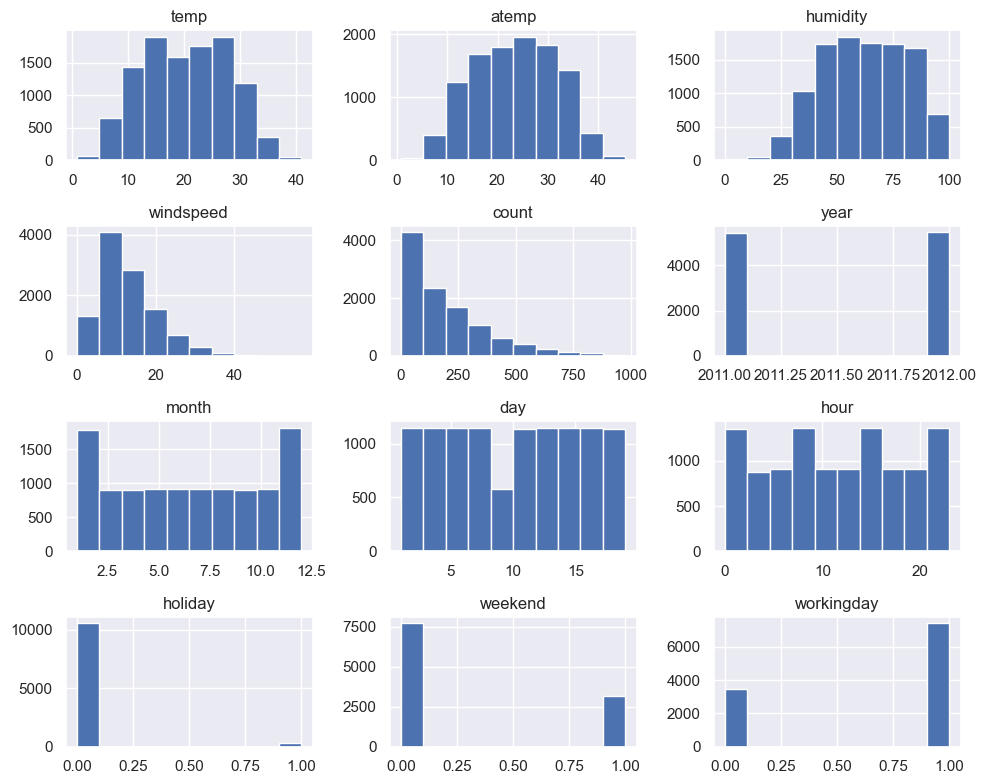

In [57]:
# View histogram of all features again now with the extra features
train.hist(figsize=(10,8))
plt.tight_layout()
plt.show();

## Step 5: Rerun the model with the same settings as before, just with more features

In [68]:
predictor_new_features = TabularPredictor(eval_metric=eval_metric,label=label,path="AutogluonModels/ag-new-features").fit(train_data=train,presets=presets,
                                                                                  time_limit=time_limit)

Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
Dynamic stacking is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
Detecting stacked overfitting by sub-fitting AutoGluon on the input data. That is, copies of AutoGluon will be sub-fit on subset(s) of the data. Then, the holdout validation data is used to detect stacked overfitting.
Sub-fit(s) time limit is: 600 seconds.
Starting holdout-based sub-fit for dynamic stacking. Context path is: AutogluonModels/ag-new-features/ds_sub_fit/sub_fit_ho.
Running the sub-fit in a ray process to avoid memory leakage.
Spend 155 seconds for the sub-fit(s) during dynamic stacking.
Time left for full fit of AutoGluon: 44

In [69]:
predictor_new_features.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                          model   score_val              eval_metric  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0           WeightedEnsemble_L3  -35.389964  root_mean_squared_error      45.276138  301.172276                0.000793           0.073207            3       True         36
1           WeightedEnsemble_L2  -35.600647  root_mean_squared_error      11.059666  139.816003                0.000287           0.034817            2       True         17
2   NeuralNetFastAI_r191_BAG_L2  -35.659862  root_mean_squared_error      44.544867  278.920816                0.224158          19.934367            2       True         28
3         ExtraTrees_r42_BAG_L2  -35.891798  root_mean_squared_error      44.628442  260.276880                0.307733           1.290431            2       True         32
4          ExtraTreesMSE_BAG_L2  -35.898039  root_mean_squared_error

{'model_types': {'KNeighborsUnif_BAG_L1': 'StackerEnsembleModel_KNN',
  'KNeighborsDist_BAG_L1': 'StackerEnsembleModel_KNN',
  'LightGBMXT_BAG_L1': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L1': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L1': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L1': 'StackerEnsembleModel_XT',
  'NeuralNetFastAI_BAG_L1': 'StackerEnsembleModel_NNFastAiTabular',
  'XGBoost_BAG_L1': 'StackerEnsembleModel_XGBoost',
  'LightGBMLarge_BAG_L1': 'StackerEnsembleModel_LGB',
  'CatBoost_r177_BAG_L1': 'StackerEnsembleModel_CatBoost',
  'LightGBM_r131_BAG_L1': 'StackerEnsembleModel_LGB',
  'NeuralNetFastAI_r191_BAG_L1': 'StackerEnsembleModel_NNFastAiTabular',
  'CatBoost_r9_BAG_L1': 'StackerEnsembleModel_CatBoost',
  'LightGBM_r96_BAG_L1': 'StackerEnsembleModel_LGB',
  'XGBoost_r33_BAG_L1': 'StackerEnsembleModel_XGBoost',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel',
  'LightGBMXT_BAG_L2': 'StackerEnsemb

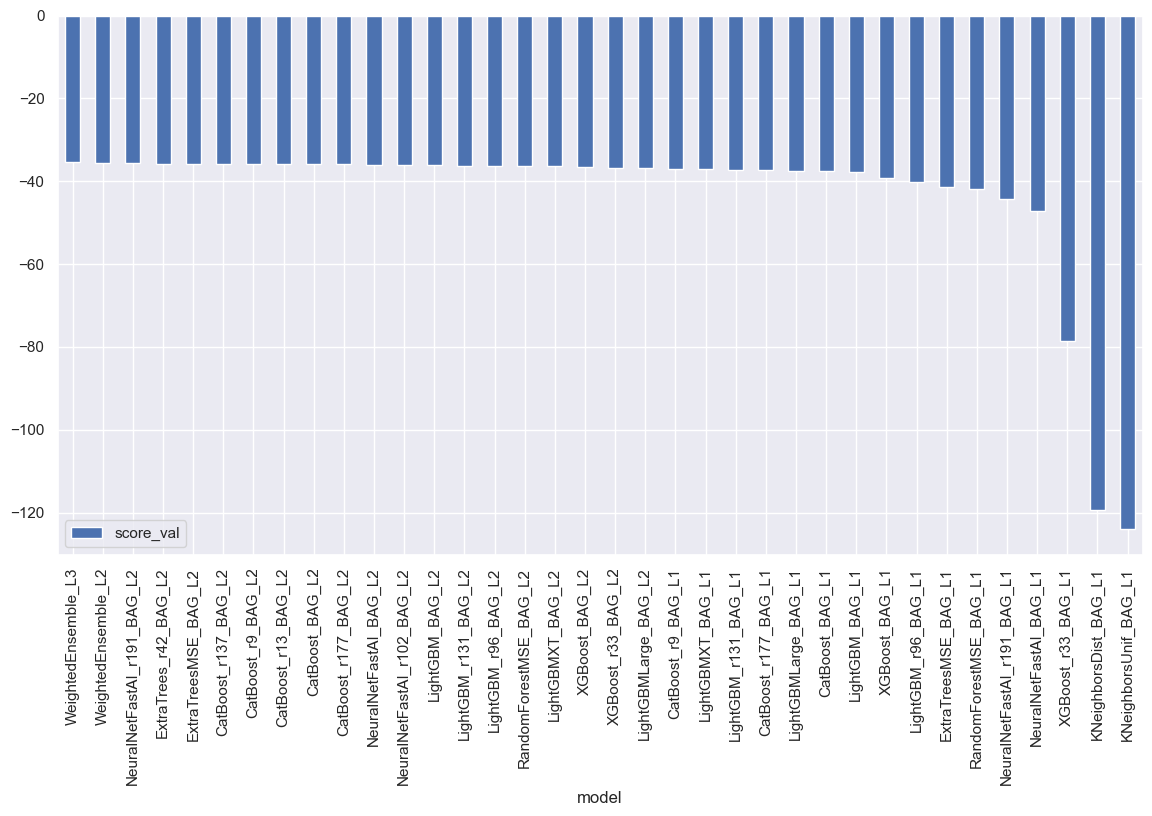

In [70]:
predictor_new_features.leaderboard(silent=True).plot(kind='bar',x='model',y='score_val',figsize=(14,7));

In [71]:
predictions_new_features = predictor_new_features.predict(test)
predictions_new_features.head()

0    13.748892
1     4.192038
2     3.148823
3     3.731641
4     3.710629
Name: count, dtype: float32

In [72]:
# Remember to set all negative values to zero
predictions_new_features[predictions_new_features<0]= 0

In [73]:
# Same submitting predictions
submission_new_features=pd.DataFrame(data=submission["datetime"])
submission_new_features["count"] = predictions_new_features
submission_new_features.to_csv("submission_new_features.csv", index=False)

In [74]:
!kaggle competitions submit -c bike-sharing-demand -f submission_new_features.csv -m "new features"

100%|█████████████████████████████████████████| 188k/188k [00:01<00:00, 120kB/s]
Successfully submitted to Bike Sharing Demand

In [75]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 7

fileName                     date                 description                        status    publicScore  privateScore  
---------------------------  -------------------  ---------------------------------  --------  -----------  ------------  
submission_new_features.csv  2024-04-30 09:29:17  new features                       complete  0.46056      0.46056       
submission_hpo_2.csv         2024-04-30 09:11:55  new hyperparameters_2              complete  0.47344      0.47344       
submission_hpo_2.csv         2024-04-30 08:47:40  new hyperparameters_2              complete  0.5089       0.5089        
submission_hpo_2.csv         2024-04-30 07:35:34  new hyperparameters_2              complete  0.5089       0.5089        


#### New Score of `0.46056`

## Step 6: Hyper parameter optimization
* There are many options for hyper parameter optimization.
* Options are to change the AutoGluon higher level parameters or the individual model hyperparameters.
* The hyperparameters of the models themselves that are in AutoGluon. Those need the `hyperparameter` and `hyperparameter_tune_kwargs` arguments.

In [ ]:
#To be run in SageMaker 
# hyperparameters.retrieve_default(
#  model_id=train_model_id, model_version=train_model_version
# )

### Step 6_1: Trial 1

In [96]:
#Defining the hyperparameter for FastAINeuralNetwork and Catboost
fastai_options = {'layer':[200,100],
                    'lr': ag.space.Real(1e-3, 1e-1, log=True),
                    'ps':ag.space.Real(1e-3,2e-1),
                    'emb_drop':ag.space.Real(1e-3,5e-2,log=True),
                    'epochs': ag.space.Int(8,25),
                    'early.stopping.patience': 7                  }
catboost_options ={ 'depth':ag.space.Int(5,15),
                     'l2_leaf_reg':ag.space.Real(0.05,5,log=True),
                     }

In [97]:
#Requirements
label = 'count'
time_limit= 600
eval_metric ='root_mean_squared_error'
presets = 'best_quality'

In [99]:
hyperparameters= {# hyperparameters of each model
    'FASTAI' :fastai_options,
    'CAT': catboost_options }

num_trials = 15            # Number of hyperparameter optimization trials you want to perform
search_strategy = 'auto'  # tune hyperparameters using Bayesian optimization routine with a local scheduler
scheduler = 'local'       # Local FIFO scheduler

hyperparameter_tune_kwargs = { 
    'num_trials': num_trials,
    'scheduler' : scheduler,
    'searcher': search_strategy,
}


In [100]:
predictor_new_hpo = TabularPredictor(path="AutogluonModels/ag-new-hpo",problem_type='regression',label=label,eval_metric='root_mean_squared_error').fit(train_data=train,presets=presets,
                                                                                  time_limit=time_limit,hyperparameters=hyperparameters,
                                                                                                                             hyperparameter_tune_kwargs=hyperparameter_tune_kwargs)

Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
Dynamic stacking is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
Detecting stacked overfitting by sub-fitting AutoGluon on the input data. That is, copies of AutoGluon will be sub-fit on subset(s) of the data. Then, the holdout validation data is used to detect stacked overfitting.
Sub-fit(s) time limit is: 600 seconds.
Starting holdout-based sub-fit for dynamic stacking. Context path is: AutogluonModels/ag-new-hpo/ds_sub_fit/sub_fit_ho.
Running the sub-fit in a ray process to avoid memory leakage.
Spend 89 seconds for the sub-fit(s) during dynamic stacking.
Time left for full fit of AutoGluon: 511 seco

  0%|          | 0/15 [00:00<?, ?it/s]

	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy (8 workers, per: cpus=1, gpus=0, memory=0.03%)
	Stopping HPO to satisfy time limit...
Fitted model: CatBoost_BAG_L1/T1 ...
	-38.6487	 = Validation score   (-root_mean_squared_error)
	82.93s	 = Training   runtime
	0.0s	 = Validation runtime
Hyperparameter tuning model: NeuralNetFastAI_BAG_L1 ... Tuning model for up to 153.25s of the 428.0s of remaining time.
Traceback (most recent call last):
  File "/Users/kalai/miniforge3/envs/env_tf/lib/python3.10/site-packages/autogluon/core/trainer/abstract_trainer.py", line 2222, in _train_single_full
    hpo_models, hpo_results = model.hyperparameter_tune(
  File "/Users/kalai/miniforge3/envs/env_tf/lib/python3.10/site-packages/autogluon/core/models/abstract/abstract_model.py", line 1474, in hyperparameter_tune
    return self._hyperparameter_tune(hpo_executor=hpo_executor, **kwargs)
  File "/Users/kalai/miniforge3/envs/env_tf/lib/python3.10/site-packages/autogl

  0%|          | 0/15 [00:00<?, ?it/s]

	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy (8 workers, per: cpus=1, gpus=0, memory=0.04%)
	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy (8 workers, per: cpus=1, gpus=0, memory=0.51%)
	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy (8 workers, per: cpus=1, gpus=0, memory=1.99%)
	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy (8 workers, per: cpus=1, gpus=0, memory=0.26%)
	Memory not enough to fit 8 folds in parallel. Will train 4 folds in parallel instead (Estimated 15.68% memory usage per fold, 62.74%/80.00% total).
	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=2, gpus=0, memory=15.68%)
	Stopping HPO to satisfy time limit...
Fitted model: CatBoost_BAG_L2/T1 ...
	-38.5143	 = Validation score   (-root_mean_squared_error)
	4.8s	 = Training   runtime
	0.0s	 = Validation ru

In [102]:
predictor_new_hpo.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                 model  score_val              eval_metric  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0  WeightedEnsemble_L3 -38.207735  root_mean_squared_error       0.000549  160.238395                0.000271           0.007300            3       True          8
1   CatBoost_BAG_L2/T4 -38.497006  root_mean_squared_error       0.000115  128.458029                0.000047          45.526559            2       True          6
2   CatBoost_BAG_L2/T1 -38.514303  root_mean_squared_error       0.000114   87.730672                0.000046           4.799202            2       True          3
3   CatBoost_BAG_L2/T2 -38.639963  root_mean_squared_error       0.000140   90.929221                0.000072           7.997751            2       True          4
4   CatBoost_BAG_L1/T1 -38.648686  root_mean_squared_error       0.000068   82.931470                0.000068         

{'model_types': {'CatBoost_BAG_L1/T1': 'StackerEnsembleModel_CatBoost',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel',
  'CatBoost_BAG_L2/T1': 'StackerEnsembleModel_CatBoost',
  'CatBoost_BAG_L2/T2': 'StackerEnsembleModel_CatBoost',
  'CatBoost_BAG_L2/T3': 'StackerEnsembleModel_CatBoost',
  'CatBoost_BAG_L2/T4': 'StackerEnsembleModel_CatBoost',
  'CatBoost_BAG_L2/T5': 'StackerEnsembleModel_CatBoost',
  'WeightedEnsemble_L3': 'WeightedEnsembleModel'},
 'model_performance': {'CatBoost_BAG_L1/T1': -38.64868595473036,
  'WeightedEnsemble_L2': -38.64868595473036,
  'CatBoost_BAG_L2/T1': -38.514302502319175,
  'CatBoost_BAG_L2/T2': -38.63996263562991,
  'CatBoost_BAG_L2/T3': -38.82502108112207,
  'CatBoost_BAG_L2/T4': -38.4970064740608,
  'CatBoost_BAG_L2/T5': -39.24214744152935,
  'WeightedEnsemble_L3': -38.20773498830155},
 'model_best': 'WeightedEnsemble_L3',
 'model_paths': {'CatBoost_BAG_L1/T1': ['CatBoost_BAG_L1', 'T1'],
  'WeightedEnsemble_L2': ['WeightedEnsemble_L2'],
  'CatBoost_

In [103]:
predictions_new_hpo=predictor_new_hpo.predict(test)
predictions_new_hpo.head()

0    12.006167
1     2.077551
2     0.876061
3     2.097647
4     2.310613
Name: count, dtype: float32

In [104]:
#Setting negative predictions to zero
predictions_new_hpo[predictions_new_hpo<0] =0

In [105]:
# Same submitting predictions
submission_new_hpo=pd.DataFrame(data=submission["datetime"])
submission_new_hpo["count"] = predictions_new_hpo
submission_new_hpo.to_csv("submission_new_hpo.csv", index=False)

In [106]:
!kaggle competitions submit -c bike-sharing-demand -f submission_new_hpo.csv -m "new features with hyperparameters"

100%|█████████████████████████████████████████| 188k/188k [00:01<00:00, 106kB/s]
Successfully submitted to Bike Sharing Demand

In [107]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 5

fileName                     date                 description                        status    publicScore  privateScore  
---------------------------  -------------------  ---------------------------------  --------  -----------  ------------  
submission_new_hpo.csv       2024-04-30 10:55:22  new features with hyperparameters  complete  0.54853      0.54853       
submission_hpo_2.csv         2024-04-30 10:25:17  new hpo_2- tweaked nn              complete  0.47297      0.47297       


#### New score of `0.54853`

### Step 6_2: Trial 2

In [17]:
import autogluon.common as ag

LightGBM_BAG_L1': {'name': 'LightGBM_BAG_L1',
   'model_type': 'StackerEnsembleModel',
   'problem_type': 'regression',
   'eval_metric': 'root_mean_squared_error',
   'stopping_metric': 'root_mean_squared_error',
   'fit_time': 3.1831910610198975,
   'num_classes': None,
   'quantile_levels': None,
   'predict_time': 1.7662253379821777,
   'val_score': -37.78091523436927,
   'hyperparameters': {'use_orig_features': True,
    'max_base_models': 25,
    'max_base_models_per_type': 5,
    'save_bag_folds': True},

In [78]:
catboost_options ={
    'depth': ag.space.Int(5,10),
    'learning_rate' :ag.space.Real(1e-3,1e-2,log=True),
    'l2_leaf_reg':ag.space.Int(2,10), #0,5
    'random_strength': ag.space.Real(1,8,log=True),
}

gbm_options= {
    'metric':'rmse',
    'learning_rate': ag.space.Real(1e-3,1e-1,log=True),
    'max_depth':ag.space.Int(15,30),
    'num_leaves':ag.space.Categorical(36,64,96)
}

xt_options= {
    'criterion': 'squared_error',
    'ag_args': {'name_suffix': 'MSE', 'problem_types': ['regression']}
}

rf_options = {
    'criterion': 'squared_error', 
    'ag_args': {'name_suffix': 'MSE', 'problem_types': ['regression']}
}
knn_options = {}
xgb_options= {
                'eval_metric': 'rmse', 
                'max_depth':ag.space.Int(lower=5, upper=10), 
                'n_estimators': ag.space.Int(lower=100, upper=450), 
                }
nn_options= {'learning_rate':ag.space.Real(1e-3,1e-2,log=True),'num_epochs':7}
#                   'hidden_size':ag.space.Categorical(256,220,178,196)} Since this is not recognised, we will exclude from trial 2

In [79]:
num_trials=5
search_strategy ='auto'
scheduler= 'local'

hyperparameter_tune_kwargs ={
    'num_trials': num_trials,
    'scheduler' : scheduler,
    'searcher': search_strategy,
}

hyperparameters= {
    'RF':rf_options ,
    'XGB':xgb_options,
    'XT': xt_options,
    'KNN': knn_options,
    'GBM':gbm_options,
    'CAT':catboost_options,
    'NN_TORCH':nn_options
    
}


In [80]:
predictor_new_hpo_1= TabularPredictor(path="AutogluonModels/ag-new-hpo-1",problem_type='regression',label=label,eval_metric='root_mean_squared_error').fit(train_data=train,presets=presets,
                                                                                  time_limit=1000,hyperparameters=hyperparameters,hyperparameter_tune_kwargs=hyperparameter_tune_kwargs)

Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
Dynamic stacking is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
Detecting stacked overfitting by sub-fitting AutoGluon on the input data. That is, copies of AutoGluon will be sub-fit on subset(s) of the data. Then, the holdout validation data is used to detect stacked overfitting.
Sub-fit(s) time limit is: 1000 seconds.
Starting holdout-based sub-fit for dynamic stacking. Context path is: AutogluonModels/ag-new-hpo-1/ds_sub_fit/sub_fit_ho.
Running the sub-fit in a ray process to avoid memory leakage.
Spend 125 seconds for the sub-fit(s) during dynamic stacking.
Time left for full fit of AutoGluon: 875 

  0%|          | 0/5 [00:00<?, ?it/s]

	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy (8 workers, per: cpus=1, gpus=0, memory=0.04%)
	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy (8 workers, per: cpus=1, gpus=0, memory=0.05%)
	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy (8 workers, per: cpus=1, gpus=0, memory=0.04%)
	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy (8 workers, per: cpus=1, gpus=0, memory=0.07%)
	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy (8 workers, per: cpus=1, gpus=0, memory=0.05%)
Fitted model: LightGBM_BAG_L1/T1 ...
	-40.5434	 = Validation score   (-root_mean_squared_error)
	13.92s	 = Training   runtime
	0.0s	 = Validation runtime
Fitted model: LightGBM_BAG_L1/T2 ...
	-37.1313	 = Validation score   (-root_mean_squared_error)
	6.93s	 = Training   runtime
	0.0s	 = Validation runtime
Fitted model: LightGBM_BAG_L

  0%|          | 0/5 [00:00<?, ?it/s]

	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy (8 workers, per: cpus=1, gpus=0, memory=0.03%)
	Stopping HPO to satisfy time limit...
Fitted model: CatBoost_BAG_L1/T1 ...
	-56.5995	 = Validation score   (-root_mean_squared_error)
	57.59s	 = Training   runtime
	0.0s	 = Validation runtime
Hyperparameter tuning model: ExtraTreesMSE_BAG_L1 ... Tuning model for up to 74.98s of the 755.99s of remaining time.
	No hyperparameter search space specified for ExtraTreesMSE_BAG_L1. Skipping HPO. Will train one model based on the provided hyperparameters.
Fitted model: ExtraTreesMSE_BAG_L1 ...
	-41.3736	 = Validation score   (-root_mean_squared_error)
	1.39s	 = Training   runtime
	0.0s	 = Validation runtime
Hyperparameter tuning model: XGBoost_BAG_L1 ... Tuning model for up to 74.98s of the 754.59s of remaining time.


  0%|          | 0/5 [00:00<?, ?it/s]

	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy (8 workers, per: cpus=1, gpus=0, memory=0.05%)
	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy (8 workers, per: cpus=1, gpus=0, memory=0.14%)
	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy (8 workers, per: cpus=1, gpus=0, memory=0.08%)
	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy (8 workers, per: cpus=1, gpus=0, memory=0.08%)
	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy (8 workers, per: cpus=1, gpus=0, memory=0.26%)
Fitted model: XGBoost_BAG_L1/T1 ...
	-45.5575	 = Validation score   (-root_mean_squared_error)
	1.75s	 = Training   runtime
	0.0s	 = Validation runtime
Fitted model: XGBoost_BAG_L1/T2 ...
	-38.8441	 = Validation score   (-root_mean_squared_error)
	2.48s	 = Training   runtime
	0.0s	 = Validation runtime
Fitted model: XGBoost_BAG_L1/T3

  0%|          | 0/5 [00:00<?, ?it/s]

	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy (8 workers, per: cpus=1, gpus=0, memory=0.08%)
	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy (8 workers, per: cpus=1, gpus=0, memory=0.10%)
	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy (8 workers, per: cpus=1, gpus=0, memory=0.08%)
	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy (8 workers, per: cpus=1, gpus=0, memory=0.13%)
	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy (8 workers, per: cpus=1, gpus=0, memory=0.11%)
Fitted model: LightGBM_BAG_L2/T1 ...
	-37.5179	 = Validation score   (-root_mean_squared_error)
	13.92s	 = Training   runtime
	0.0s	 = Validation runtime
Fitted model: LightGBM_BAG_L2/T2 ...
	-37.6886	 = Validation score   (-root_mean_squared_error)
	2.83s	 = Training   runtime
	0.0s	 = Validation runtime
Fitted model: LightGBM_BAG_L

  0%|          | 0/5 [00:00<?, ?it/s]

	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy (8 workers, per: cpus=1, gpus=0, memory=0.07%)
	Stopping HPO to satisfy time limit...
Fitted model: CatBoost_BAG_L2/T1 ...
	-37.1453	 = Validation score   (-root_mean_squared_error)
	86.86s	 = Training   runtime
	0.0s	 = Validation runtime
Hyperparameter tuning model: ExtraTreesMSE_BAG_L2 ... Tuning model for up to 111.37s of the 617.59s of remaining time.
	No hyperparameter search space specified for ExtraTreesMSE_BAG_L2. Skipping HPO. Will train one model based on the provided hyperparameters.
Fitted model: ExtraTreesMSE_BAG_L2 ...
	-37.0872	 = Validation score   (-root_mean_squared_error)
	1.99s	 = Training   runtime
	0.0s	 = Validation runtime
Hyperparameter tuning model: XGBoost_BAG_L2 ... Tuning model for up to 111.37s of the 615.56s of remaining time.


  0%|          | 0/5 [00:00<?, ?it/s]

	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy (8 workers, per: cpus=1, gpus=0, memory=0.11%)
	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy (8 workers, per: cpus=1, gpus=0, memory=0.31%)
	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy (8 workers, per: cpus=1, gpus=0, memory=0.18%)
	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy (8 workers, per: cpus=1, gpus=0, memory=0.18%)
	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy (8 workers, per: cpus=1, gpus=0, memory=0.56%)
Fitted model: XGBoost_BAG_L2/T1 ...
	-37.3888	 = Validation score   (-root_mean_squared_error)
	2.11s	 = Training   runtime
	0.0s	 = Validation runtime
Fitted model: XGBoost_BAG_L2/T2 ...
	-37.8874	 = Validation score   (-root_mean_squared_error)
	3.14s	 = Training   runtime
	0.0s	 = Validation runtime
Fitted model: XGBoost_BAG_L2/T3

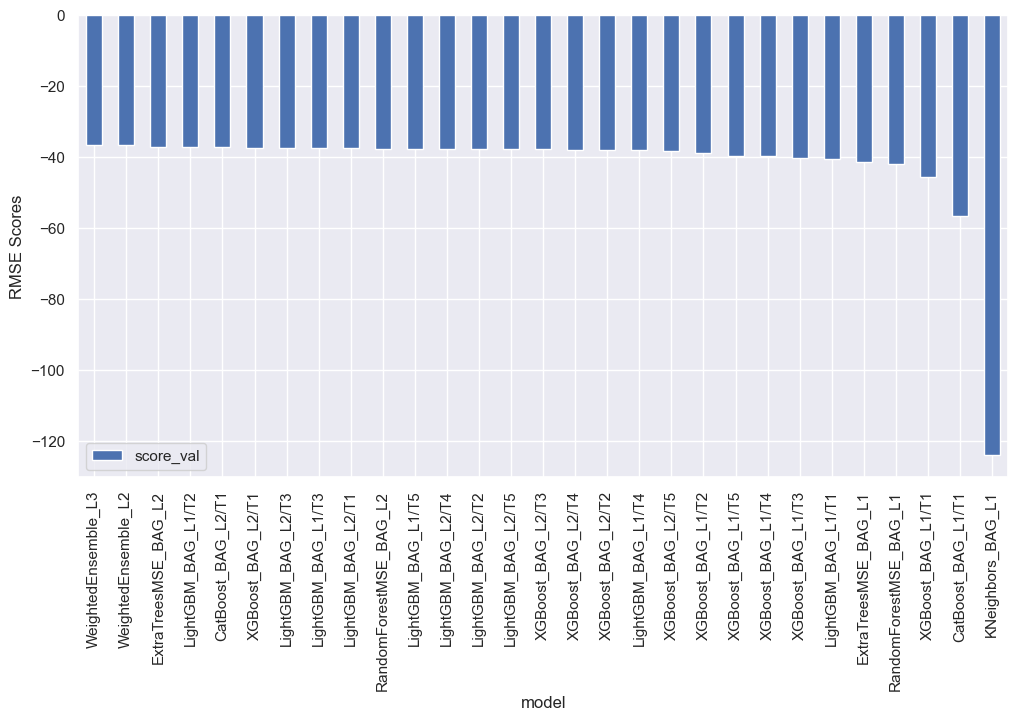

In [81]:
# Output the model's `score_val` in a bar chart to compare performance
leaderboard_new_hpo1_df = pd.DataFrame(predictor_new_hpo_1.leaderboard(silent=True))
leaderboard_new_hpo1_df.plot(kind="bar", x="model", y="score_val", figsize=(12, 6))
plt.ylabel("RMSE Scores")
plt.show()

In [82]:
predictor_new_hpo_1.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                     model   score_val              eval_metric  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0      WeightedEnsemble_L3  -36.651535  root_mean_squared_error       0.002070  225.680523                0.000386           0.077242            3       True         29
1      WeightedEnsemble_L2  -36.657980  root_mean_squared_error       0.000597   48.877224                0.000277           0.020738            2       True         15
2     ExtraTreesMSE_BAG_L2  -37.087241  root_mean_squared_error       0.001539  134.275856                0.000070           1.993405            2       True         23
3       LightGBM_BAG_L1/T2  -37.131328  root_mean_squared_error       0.000048    6.926835                0.000048           6.926835            1       True          3
4       CatBoost_BAG_L2/T1  -37.145264  root_mean_squared_error       0.001522  219.146403   

{'model_types': {'KNeighbors_BAG_L1': 'StackerEnsembleModel_KNN',
  'LightGBM_BAG_L1/T1': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1/T2': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1/T3': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1/T4': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1/T5': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L1': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L1/T1': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L1': 'StackerEnsembleModel_XT',
  'XGBoost_BAG_L1/T1': 'StackerEnsembleModel_XGBoost',
  'XGBoost_BAG_L1/T2': 'StackerEnsembleModel_XGBoost',
  'XGBoost_BAG_L1/T3': 'StackerEnsembleModel_XGBoost',
  'XGBoost_BAG_L1/T4': 'StackerEnsembleModel_XGBoost',
  'XGBoost_BAG_L1/T5': 'StackerEnsembleModel_XGBoost',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel',
  'LightGBM_BAG_L2/T1': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L2/T2': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L2/T3': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L2/T4': 'Sta

In [83]:
predictions_hpo_2 = predictor_new_hpo_1.predict(test)
predictions_hpo_2.head()

0    14.520658
1     2.549029
2     1.045318
3     2.414469
4     2.354971
Name: count, dtype: float32

In [84]:
predictions_hpo_2[predictions_hpo_2<0]= 0
# Same submitting predictions
submission_hpo_2=pd.DataFrame(data=submission["datetime"])
submission_hpo_2["count"] = predictions_hpo_2
submission_hpo_2.to_csv("submission_hpo_2.csv", index=False)

In [85]:
!kaggle competitions submit -c bike-sharing-demand -f submission_hpo_2.csv -m "new hpo_2- tweaked nn"

100%|█████████████████████████████████████████| 188k/188k [00:01<00:00, 109kB/s]
Successfully submitted to Bike Sharing Demand

In [88]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 11

fileName                     date                 description                        status    publicScore  privateScore  
---------------------------  -------------------  ---------------------------------  --------  -----------  ------------  
submission_hpo_2.csv         2024-04-30 10:25:17  new hpo_2- tweaked nn              complete  0.47297      0.47297       
submission_new_features.csv  2024-04-30 09:29:17  new features                       complete  0.46056      0.46056       
submission_hpo_2.csv         2024-04-30 09:11:55  new hyperparameters_2              complete  0.47344      0.47344       
submission_hpo_2.csv         2024-04-30 08:47:40  new hyperparameters_2              complete  0.5089       0.5089        
submission_hpo_2.csv         2024-04-30 07:35:34  new hyperparameters_2              complete  0.5089       0.5089        
submission_hpo_2.csv         2024-04-29 22:27:20  new hyperparameters_2              complete  0.51375      0.51375       
submission_hpo_2

#### New Score of `0.47297`

## Step 7: Write a Report
### Refer to the markdown file for the full report
### Creating plots and table for report

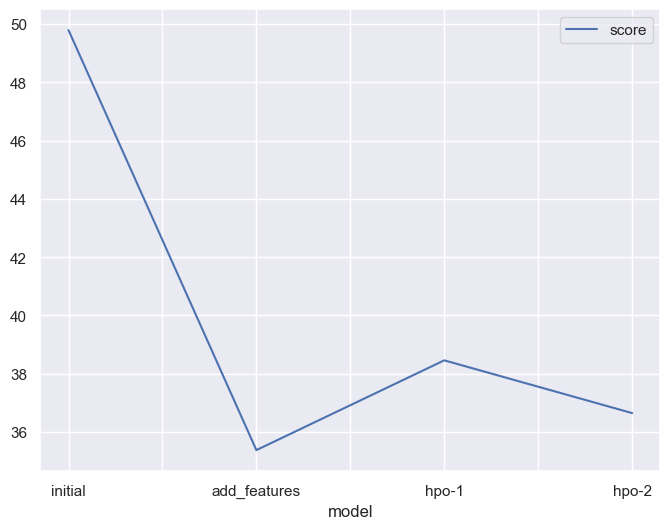

In [92]:
# Taking the top model score from each training run and creating a line plot to show improvement
# You can create these in the notebook and save them to PNG or use some other tool (e.g. google sheets, excel)
fig = pd.DataFrame(
    {
        "model": ["initial", "add_features", "hpo-1","hpo-2"],
        "score": [49.79 ,35.38 , 38.46,36.65]
    }
).plot(x="model", y="score", figsize=(8, 6)).get_figure()
fig.savefig('model_train_score.png')

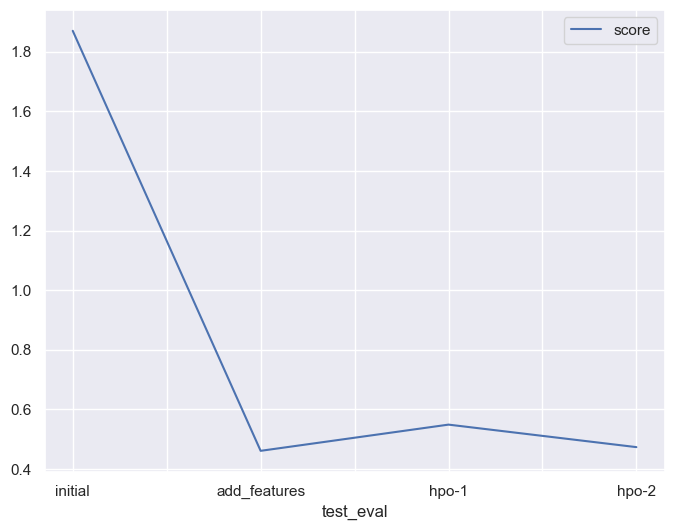

In [109]:
# Take the 3 kaggle scores and creating a line plot to show improvement
fig = pd.DataFrame(
    {
        "test_eval": ["initial", "add_features", "hpo-1","hpo-2"],
        "score": [1.8704, 0.46056, 0.54853,0.47297]
    }
).plot(x="test_eval", y="score", figsize=(8, 6)).get_figure()
fig.savefig('model_test_score.png')

### Hyperparameter table

In [119]:
# The 3 hyperparameters we tuned with the kaggle score as the result
pd.DataFrame({
    "model": ["initial", "add_features", "hpo","hpo2"],
    "hpo1": ["prescribed vals" ,"prescribed vals","n_trials: 15" ,"n_trials: 5" ],
    "hpo2": ["prescribed vals", "prescribed vals" ,' (NNFastAI,CAT)',"(CAT,GBM, XT, XGB & RF,KNN)"] ,
    "hpo3": ["presets: 'high_quality (auto_stack=True)'", "preset: 'high_quality (auto_stack=True)'","preset:'high_quality (auto_stack=True)'","preset:'high_quality',time_limit:900"],
    "score": [1.8704, 0.46056, 0.54853,0.47297]
})

,model,hpo1,hpo2,hpo3,score
0,initial,prescribed vals,prescribed vals,presets: 'high_quality (auto_stack=True)',1.87040
1,add_features,prescribed vals,prescribed vals,preset: 'high_quality (auto_stack=True)',0.46056
2,hpo,n_trials: 15,"(NNFastAI,CAT)",preset:'high_quality (auto_stack=True)',0.54853
3,hpo2,n_trials: 5,"(CAT,GBM, XT, XGB & RF,KNN)","preset:'high_quality',time_limit:900",0.47297


In [122]:
#Saving the modified train and test datasets as csv
train.to_csv("train_modified.csv",index=False)
test.to_csv("test_modified.csv",index=False)